# make numpy array for training

In [1]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable
import sys
sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from models import NormalizingFlowModel

In [3]:
#f_rnd = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/LHC-Olympics/Code/Nsubjettiness_mjj.h5")

In [4]:
rnd_data = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")

testprior_data = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/delphes_output_4500_500_150.h5")

In [5]:
rnd_data.columns

Index(['Mjj', 'j1 pT', 'j2 pT', 'Mj1', 'j1 tau21', 'j1 tau32', 'j1 tau43',
       'j1 tau54', 'j1 tau65', 'j1 tau76', 'j1 tau87',
       'j1 sqrt(tau^2_1)/tau^1_1', 'j1 n_trk', 'j1 M_trim', 'j1 M_prun',
       'j1 M_mmdt', 'j1 M_sdb1', 'j1 M_sdb2', 'j1 M_sdm1', 'Mj2', 'j2 tau21',
       'j2 tau32', 'j2 tau43', 'j2 tau54', 'j2 tau65', 'j2 tau76', 'j2 tau87',
       'j2 sqrt(tau^2_1)/tau^1_1', 'j2 n_trk', 'j2 M_trim', 'j2 M_prun',
       'j2 M_mmdt', 'j2 M_sdb1', 'j2 M_sdb2', 'j2 M_sdm1', 'isSignal'],
      dtype='object')

In [6]:
rnd_data.columns[[3,4,5,6,7,8,11,12,19,20,21,22,23,24,27,28]]

Index(['Mj1', 'j1 tau21', 'j1 tau32', 'j1 tau43', 'j1 tau54', 'j1 tau65',
       'j1 sqrt(tau^2_1)/tau^1_1', 'j1 n_trk', 'Mj2', 'j2 tau21', 'j2 tau32',
       'j2 tau43', 'j2 tau54', 'j2 tau65', 'j2 sqrt(tau^2_1)/tau^1_1',
       'j2 n_trk'],
      dtype='object')

In [7]:
rnd_data.columns[[13,14,15,16,17,18]]

Index(['j1 M_trim', 'j1 M_prun', 'j1 M_mmdt', 'j1 M_sdb1', 'j1 M_sdb2',
       'j1 M_sdm1'],
      dtype='object')

In [8]:
# pasties

In [9]:
dt = rnd_data.values
dt_prior = testprior_data.values

correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt_prior[:,3]>0) &(dt_prior[:,19]>0) & (dt_prior[:,1]>0) & (dt_prior[:,2]>0)
dt_prior = dt_prior[correct]

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

for i in range(13,19):
    dt_prior[:,i] = dt_prior[:,i]/dt_prior[:,3]

for i in range(29,35):
    dt_prior[:,i] = dt_prior[:,i]/(dt_prior[:,19])
#correct = (dt[:,16]>0) & (dt[:,29]>=0) & (dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
#dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#bkg_idx = np.where(idx==0)[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
correct = (dt[:,0]>=2800)
dt = dt[correct]   

correct = (dt_prior[:,0]>=2800)
dt_prior = dt_prior[correct] 

idx = dt[:,-1]
sig_idx = np.where((dt_prior[:,3]>450) & (dt_prior[:,3]<550) & (dt_prior[:,19]>100) & (dt_prior[:,19]<200) & (dt_prior[:,0]>4200) & (dt_prior[:,0]<4800))[0]
bkg_idx = np.where(idx==0)[0]
#bsmlike = np.where(dt[:,16]>0.9)[0]
#dt = dt[bsmlike]

dt_sig = dt_prior[sig_idx]
dt_bkg = dt[bkg_idx]




In [10]:
dt_sig.shape

(26448, 35)

In [11]:
dt_bkg.shape

(587907, 36)

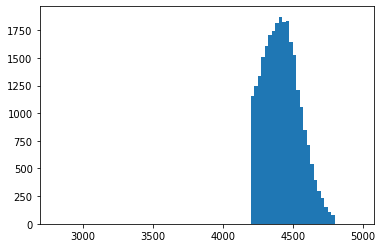

In [12]:
plt.hist(dt_sig[:,0],bins=np.arange(2800,5000,25));

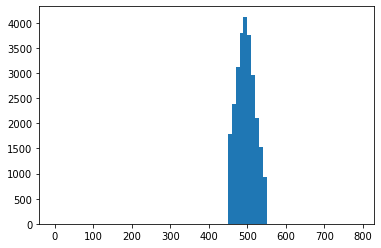

In [13]:
plt.hist(dt_sig[:,3],bins=np.arange(0,800,10));

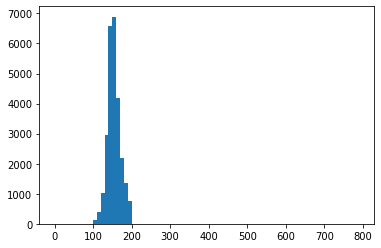

In [14]:
plt.hist(dt_sig[:,19],bins=np.arange(0,800,10));

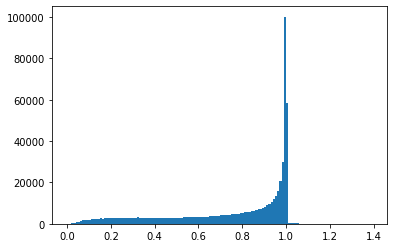

In [15]:
plt.hist(dt_bkg[:,16],bins=np.arange(0,1.4,0.01));

In [16]:
X_12feats = np.concatenate((dt_sig[:,[3,4,5,6,11,12,19,20,21,22,27,28]],dt_bkg[:,[3,4,5,6,11,12,19,20,21,22,27,28]]),axis=0)

In [17]:
X = np.concatenate((dt_sig[:,[4,5,6,11,12,20,21,22,27,28]],dt_bkg[:,[4,5,6,11,12,20,21,22,27,28]]),axis=0)

In [18]:
X_12feats.shape

(614355, 12)

In [19]:
X.shape

(614355, 10)

In [20]:
mean_10feats = []
std_10feats = []
for i in range(10):
    mean = np.mean(X[:,i])
    std = np.std(X[:,i])
    mean_10feats.append(mean)
    std_10feats.append(std)
    X[:,i] = (X[:,i]-mean)/std

In [21]:
mean_12feats = []
std_12feats = []
for i in range(12):
    mean = np.mean(X_12feats[:,i])
    std = np.std(X_12feats[:,i])
    mean_12feats.append(mean)
    std_12feats.append(std)
    X_12feats[:,i] = (X_12feats[:,i]-mean)/std

In [22]:
mean_10feats

[0.4913219196619188,
 0.7030808330657747,
 0.7987748757503985,
 1.936875648724755,
 255.11161462021144,
 0.5719545439036364,
 0.7302313375218474,
 0.7982154766868993,
 2.3744742683630142,
 159.7282678581602]

In [23]:
mean_12feats

[241.0996571174771,
 0.4913219196619188,
 0.7030808330657747,
 0.7987748757503985,
 1.936875648724755,
 255.11161462021144,
 106.88165180948343,
 0.5719545439036364,
 0.7302313375218474,
 0.7982154766868993,
 2.3744742683630142,
 159.7282678581602]

In [24]:
idx = dt[:,-1]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

In [25]:
X.shape

(614355, 10)

In [26]:
y = np.concatenate((np.ones(len(dt_sig[:,0])),np.zeros(len(dt_bkg[:,0]))))

In [27]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [28]:
y.shape

(614355,)

# Normalize Inputs

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(
#    X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42)

In [31]:
print(X_train.shape, X_val.shape, X_test.shape)

(491484, 10) (61435, 10) (61436, 10)


In [32]:
class trainData(utils.Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



## test data    
class testData(utils.Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    



In [33]:
train_data = trainData(torch.FloatTensor(X_train.astype(np.float)),torch.FloatTensor(y_train.astype(np.float)))
val_data = trainData(torch.FloatTensor(X_val.astype(np.float)),torch.FloatTensor(y_val.astype(np.float)))
test_data = testData(torch.FloatTensor(X_test.astype(np.float))) 

# Make Dataloader

In [34]:
import torch

In [35]:
torch.cuda.is_available()

True

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'GeForce GTX 1080 Ti'

In [37]:
BATCH_SIZE = 1000
N_EPOCHS = 80
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

# NN classifier

In [38]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(10,84)
        self.linear2 = nn.Linear(84,42)
        self.linear3 = nn.Linear(42,21)
        self.linear4 = nn.Linear(21,10)
        self.linear5 = nn.Linear(10,5)
        self.linear_out = nn.Linear(5,1)
        
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(84)
        self.batchnorm2 = nn.BatchNorm1d(42)
        self.batchnorm3 = nn.BatchNorm1d(21)
        self.batchnorm4 = nn.BatchNorm1d(10)
        self.batchnorm5 = nn.BatchNorm1d(5)
        

    def forward(self, x):
        x = self.batchnorm1(self.linear1(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm2(self.linear2(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm3(self.linear3(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm4(self.linear4(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm5(self.linear5(x))
        x = F.leaky_relu(x)
        x = self.linear_out(x)
        return x





In [39]:
model = Net()

print(model)
model.to(device)

Net(
  (linear1): Linear(in_features=10, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=42, bias=True)
  (linear3): Linear(in_features=42, out_features=21, bias=True)
  (linear4): Linear(in_features=21, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=5, bias=True)
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Net(
  (linear1): Linear(in_features=10, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=42, bias=True)
  (linear3): Linear(in_features=42, out_features=21, bias=True)
  (linear4): Linear(in_features=21, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=5, bias=True)
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [40]:
from torchsummary import summary


In [41]:
summary(model,(10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 84]             924
       BatchNorm1d-2                   [-1, 84]             168
           Dropout-3                   [-1, 84]               0
            Linear-4                   [-1, 42]           3,570
       BatchNorm1d-5                   [-1, 42]              84
           Dropout-6                   [-1, 42]               0
            Linear-7                   [-1, 21]             903
       BatchNorm1d-8                   [-1, 21]              42
           Dropout-9                   [-1, 21]               0
           Linear-10                   [-1, 10]             220
      BatchNorm1d-11                   [-1, 10]              20
          Dropout-12                   [-1, 10]               0
           Linear-13                    [-1, 5]              55
      BatchNorm1d-14                   

In [42]:
# optimizer
#lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=1e-6)
criterion = nn.BCEWithLogitsLoss()

In [43]:
device

device(type='cuda', index=0)

In [44]:
train_loader = utils.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = utils.DataLoader(dataset=val_data, batch_size=100)
test_loader = utils.DataLoader(dataset=test_data, batch_size=100)

In [45]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [46]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    epoch_loss = 0
    epoch_acc = 0

    for x, y in train_loader:
        # reshape the data into [batch_size, 784]
        x,y = x.to(device), y.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        y_pred = model(x)

        # reconstruction loss
        #recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        #kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        #loss = recon_loss + kl_loss

        #BCE loss
        loss = criterion(y_pred, y.unsqueeze(1))
        acc = binary_acc(y_pred, y.unsqueeze(1))
        
        # backward pass
        loss.backward()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # update the weights
        optimizer.step()

    return epoch_loss


In [47]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for x, y in val_loader:
            # reshape the data
            #x = x.view(-1, 28 * 28)
            x,y = x.to(device), y.to(device)
            # forward pass
            y_pred = model(x)

            loss = criterion(y_pred, y.unsqueeze(1))
            acc = binary_acc(y_pred, y.unsqueeze(1))
            # total loss
            
            test_loss += loss.item()

    return test_loss

In [48]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/supervised_noDDT_testprior4500500150_10inputs_on_2prong.h5"))

<All keys matched successfully>

In [ ]:
best_test_loss = 999
patience_counter = 0
for e in range(500):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_data)
    test_loss /= len(val_data)

    print(f'Epoch {e}, Train Loss: {train_loss:.7f}, Test Loss: {test_loss:.7f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "/data/t3home000/spark/QUASAR/weights/supervised_noDDT_testprior4500500150_10inputs_on_2prong.h5")
        patience_counter = 1
        print('saving model')
    else:
        print('NOT SAVING')
        patience_counter += 1

    if patience_counter > 10:
        print('patience limit reached')
        break

In [49]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/supervised_noDDT_testprior4500500150_10inputs_on_2prong.h5"))

<All keys matched successfully>

In [50]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 10)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

class VAE_NF_12feat(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(12, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 12)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div
    

#sigmodel = VAE_NF(N_FLOWS, Z_DIM).cuda()

sigmodel = VAE_NF_12feat(10, 4).cuda()
bkgmodel = VAE_NF_12feat(10, 4).cuda()
sig2model = VAE_NF_12feat(10, 4).cuda()

sigae_def = {
                        "type":"sig",
                        "trainon":"2prong",
                        "features":"12features",
                        "architecture":"MAF",
                        "selection":"mjjcut",
                        "trainloss":"MSELoss",
                        "beta":f"beta10p0",
                        "zdimnflow":f"z4f10",
                        "version":f"ver0"

                     }

bkgae_def = {
                        "type":"bkg",
                        "trainon":"rndbkg",
                        "features":"12features",
                        "architecture":"MAF",
                        "selection":"mjjcut",
                        "trainloss":"MSELoss",
                        "beta":f"beta10p0",
                        "zdimnflow":f"z4f10",
                        "version":f"ver0"

                     }

sigae3prong_def = {
                        "type":"sig",
                        "trainon":"3prong",
                        "features":"12features",
                        "architecture":"MAF",
                        "selection":"mjjcut",
                        "trainloss":"MSELoss",
                        "beta":f"beta10p0",
                        "zdimnflow":f"z4f10",
                        "version":f"ver0"

                     }

directory = '/data/t3home000/spark/QUASAR/weights'
bkgmodel.load_state_dict(torch.load(f"{directory}/{bkgae_def['type']}_{bkgae_def['trainon']}_{bkgae_def['features']}_{bkgae_def['architecture']}_{bkgae_def['selection']}_{bkgae_def['trainloss']}_{bkgae_def['beta']}_{bkgae_def['zdimnflow']}_{bkgae_def['version']}.h5"))
sigmodel.load_state_dict(torch.load(f"{directory}/{sigae_def['type']}_{sigae_def['trainon']}_{sigae_def['features']}_{sigae_def['architecture']}_{sigae_def['selection']}_{sigae_def['trainloss']}_{sigae_def['beta']}_{sigae_def['zdimnflow']}_{sigae_def['version']}.h5"))
sig2model.load_state_dict(torch.load(f"{directory}/{sigae3prong_def['type']}_{sigae3prong_def['trainon']}_{sigae3prong_def['features']}_{sigae3prong_def['architecture']}_{sigae3prong_def['selection']}_{sigae3prong_def['trainloss']}_{sigae3prong_def['beta']}_{sigae3prong_def['zdimnflow']}_{sigae3prong_def['version']}.h5"))


bkgloss_rndbkg = np.load(f"../data_strings/{bkgae_def['type']}_{bkgae_def['trainon']}_{bkgae_def['features']}_{bkgae_def['architecture']}_{bkgae_def['selection']}_{bkgae_def['trainloss']}_{bkgae_def['beta']}_{bkgae_def['zdimnflow']}_{bkgae_def['version']}_bkgloss.npy")
sigloss_rndbkg = np.load(f"../data_strings/{sigae_def['type']}_{sigae_def['trainon']}_{sigae_def['features']}_{sigae_def['architecture']}_{sigae_def['selection']}_{sigae_def['trainloss']}_{sigae_def['beta']}_{sigae_def['zdimnflow']}_{sigae_def['version']}_bkgloss.npy")
bkgloss_prong2 = np.load(f"../data_strings/{bkgae_def['type']}_{bkgae_def['trainon']}_{bkgae_def['features']}_{bkgae_def['architecture']}_{bkgae_def['selection']}_{bkgae_def['trainloss']}_{bkgae_def['beta']}_{bkgae_def['zdimnflow']}_{bkgae_def['version']}_sigloss.npy")
sigloss_prong2 = np.load(f"../data_strings/{sigae_def['type']}_{sigae_def['trainon']}_{sigae_def['features']}_{sigae_def['architecture']}_{sigae_def['selection']}_{sigae_def['trainloss']}_{sigae_def['beta']}_{sigae_def['zdimnflow']}_{sigae_def['version']}_sigloss.npy")

sig2loss_rndbkg = np.load(f"../data_strings/{sigae3prong_def['type']}_{sigae3prong_def['trainon']}_{sigae3prong_def['features']}_{sigae3prong_def['architecture']}_{sigae3prong_def['selection']}_{sigae3prong_def['trainloss']}_{sigae3prong_def['beta']}_{sigae3prong_def['zdimnflow']}_{sigae3prong_def['version']}_bkgloss.npy")
sig2loss_prong2 = np.load(f"../data_strings/{sigae3prong_def['type']}_{sigae3prong_def['trainon']}_{sigae3prong_def['features']}_{sigae3prong_def['architecture']}_{sigae3prong_def['selection']}_{sigae3prong_def['trainloss']}_{sigae3prong_def['beta']}_{sigae3prong_def['zdimnflow']}_{sigae3prong_def['version']}_sigloss.npy")



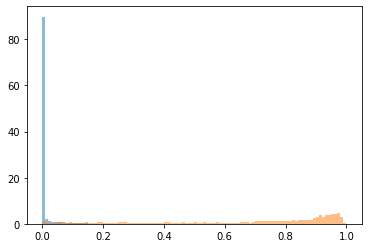

In [51]:
model.eval()
y_pred_list = np.array([],dtype=np.float)
with torch.no_grad():
    for batch_idx, X_batch in enumerate(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_pred_list = np.append(y_pred_list,y_test_pred.cpu().numpy())
        

truesig = np.where(y_test==1)
truebkg = np.where(y_test==0)
sigscore = y_pred_list[truesig]
bkgscore = y_pred_list[truebkg]

plt.hist(bkgscore,bins=np.linspace(0,1,101),alpha=.5,density=True);
plt.hist(sigscore,bins=np.linspace(0,1,101),alpha=.5,density=True);

In [52]:
twoprong_wps = ([3200, 500, 150],[4000, 500, 150],[4500, 500, 150],[5000, 500, 150],[5500, 500, 150],[6000, 500, 150])
threeprong_wps = ([4500,300,300],[5000,500,500],[5500,700,700],[6000, 900, 900])
varyj1mass_wps = ([4000, 150, 150],[4000, 300, 150],[4000, 450, 150],[4000, 500, 150],[4000, 650, 150],[4000, 700, 150],[4000, 850, 150],[4000, 900, 150])
varyjetmass_wps = ([4500, 500, 150],[4500, 700, 150],[4500, 500, 300],[4500, 700, 300],[6000, 700, 150],[6000, 500, 300],[6000, 700, 300])

In [53]:
twoprong_wps

([3200, 500, 150],
 [4000, 500, 150],
 [4500, 500, 150],
 [5000, 500, 150],
 [5500, 500, 150],
 [6000, 500, 150])

In [54]:
def get_tpr_fpr(sigscore,bkgscore):
    bins = np.linspace(0,1,20001)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigscore>cut)[0].shape[0]/len(sigscore))
        fpr.append(np.where(bkgscore>cut)[0].shape[0]/len(bkgscore))

    return tpr,fpr

In [56]:
def get_tpr_fpr_sig(sigloss,bkgloss):
    bins = np.arange(0.,25,.01)
    tpr = []
    fpr = []
    for cut in bins:
        #print(sigloss)
        #print(bkgloss)
        #print("fpr:",np.where(bkgloss<cut)[0].shape[0]/len(bkgloss),"tpr",np.where(sigloss<cut)[0].shape[0]/len(sigloss))
        tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))

    return tpr,fpr

In [57]:
def get_tpr_fpr_bkg(sigloss,bkgloss):
    bins = np.arange(0.,25,.01)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))

    return tpr,fpr

In [55]:
def get_loss_from_priors(which_prong, mjj, j1mass, j2mass):
    
    bkg_mean = [229.63703733315916,
 0.5040889514020693,
 0.7057013083107537,
 0.7997482828680078,
 1.962088799505638,
 255.28311110430732,
 104.75378636669201,
 0.5826962213587913,
 0.7337977883611374,
 0.7995755223103627,
 2.4171146383976034,
 159.75951298419648]
    
    bkg_std = [131.99460164832075,
 0.1849760683347428,
 0.12816197632833803,
 0.0865553075423761,
 0.7978444985340304,
 111.36202699158525,
 68.17314726646633,
 0.17458368821556094,
 0.11581000682757887,
 0.08481896882883566,
 1.1084488583498446,
 83.52566008451547]
    
    sig_mean = [489.6699791129437,
 0.22463354907052815,
 0.639679230886038,
 0.7742464847783065,
 1.4122267488712905,
 253.95296492556145,
 167.8782919951573,
 0.3429350853771621,
 0.6460772390759577,
 0.7653966882661628,
 1.4541020071952622,
 165.34100428967955]
    
    sig_std = [66.87936517220672,
 0.1361910116638729,
 0.15309413231859276,
 0.10054671892302457,
 0.3833027691949484,
 87.45977372109115,
 50.53622336909848,
 0.14930126292179366,
 0.15096516491915418,
 0.10415175051343364,
 0.44297590229588857,
 55.44436453890166]
    
    
    sig2_mean = [539.8230906175115,
 0.3093919504152834,
 0.5743852002513076,
 0.7250999951321894,
 1.3980643297136106,
 305.10717416378316,
 417.50598164552935,
 0.3423973996112709,
 0.5859205785605542,
 0.7492831266044925,
 1.6350968023267969,
 261.31617070357555]
    
    sig2_std = [104.54956422929888,
 0.12679648500311186,
 0.13543619747203547,
 0.11808533829680096,
 0.34103400809131684,
 100.12586819876644,
 88.97967256083908,
 0.1495063860755517,
 0.14289850921322486,
 0.11224475793826029,
 0.5509216479879365,
 82.84269505360622]
    
    #supervised_loss_list = []
    #sigae_loss_list = []
    #bkgae_loss_list = []
    filename = {
        
        '2prong':'/data/t3home000/spark/QUASAR/preprocessing/delphes_output',
        '3prong':'/data/t3home000/spark/QUASAR/preprocessing/ThreeProng'            
    
    }
    
    f = pd.read_hdf(f"{filename[which_prong]}_{mjj}_{j1mass}_{j2mass}.h5")
    dt = f.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
    correct = (dt[:,0]>mjj-300) & (dt[:,0]<mjj+300)
    dt = dt[correct]

    correct = (dt[:,3]>j1mass-100) & (dt[:,3]<j1mass+100) & (dt[:,19]>j2mass-100) & (dt[:,19]<j2mass+100)
    dt = dt[correct]
    X_no_jetmass = dt[:,[4,5,6,11,12,20,21,22,27,28]]
    X_with_jetmass = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    X_sig = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    X_bkg = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    X_sig2 = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

    for i, (mean, std) in enumerate(zip(mean_10feats, std_10feats)):
        X_no_jetmass[:,i] = (X_no_jetmass[:,i]-mean)/std
        
    for i, (bkgmean,bkgstd,sigmean,sigstd,sig2mean,sig2std) in enumerate(zip(bkg_mean,bkg_std,sig_mean, sig_std,sig2_mean,sig2_std)):
        X_bkg[:,i] = (X_with_jetmass[:,i]-bkgmean)/bkgstd
        X_sig[:,i] = (X_with_jetmass[:,i]-sigmean)/sigstd
        X_sig2[:,i] = (X_with_jetmass[:,i]-sig2mean)/sig2std
        #print(bkgmean,bkgstd)
        
    bkgae_test = torch.tensor(X_bkg)
    sigae_test = torch.tensor(X_sig)
    sigae2_test = torch.tensor(X_sig2)
    
    testprior_data = testData(torch.FloatTensor(X_no_jetmass.astype(np.float))) 
    testprior_loader = utils.DataLoader(dataset=testprior_data, batch_size=100)

    y_testpriorlist = []
    with torch.no_grad():
        for batch_idx, X_batch in enumerate(testprior_loader):
            X_batch = X_batch.to(device)
            model.eval()
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            #y_pred_tag = torch.round(y_test_pred)
            y_testpriorlist = np.append(y_testpriorlist,y_test_pred.cpu().numpy())
    
    
    
    sigmodel.eval()
    bkgmodel.eval()
    sig2model.eval()
    sigae_loss = torch.mean((sigmodel(sigae_test.float().cuda())[0]- sigae_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bkgae_loss = torch.mean((bkgmodel(bkgae_test.float().cuda())[0]- bkgae_test.float().cuda())**2,dim=1).data.cpu().numpy()
    sigae2_loss = torch.mean((sig2model(sigae2_test.float().cuda())[0]- sigae2_test.float().cuda())**2,dim=1).data.cpu().numpy()
    

    return y_testpriorlist, sigae_loss, sigae2_loss, bkgae_loss

        
    
    

In [56]:
supervised_loss_list, sigae_loss_list, sigae2_loss_list, bkgae_loss_list = [], [], [], []
for mjj, j1mass, j2mass in varyjetmass_wps:
    supervised_loss, sigae_loss, sigae2_loss, bkgae_loss = get_loss_from_priors('2prong', mjj, j1mass, j2mass)
    supervised_loss_list.append(supervised_loss)    
    sigae_loss_list.append(sigae_loss)
    sigae2_loss_list.append(sigae2_loss)
    bkgae_loss_list.append(bkgae_loss)

In [57]:
threeprong_wps

([4500, 300, 300], [5000, 500, 500], [5500, 700, 700], [6000, 900, 900])

In [58]:
threeprong_wps_temp = threeprong_wps[:2]

In [59]:
threeprong_wps_temp

([4500, 300, 300], [5000, 500, 500])

In [84]:
supervised_loss_list, sigae_loss_list, sigae2_loss_list, bkgae_loss_list = [], [], [], []
for mjj, j1mass, j2mass in threeprong_wps_temp:
    supervised_loss, sigae_loss, sigae2_loss, bkgae_loss = get_loss_from_priors('3prong', mjj, j1mass, j2mass)
    supervised_loss_list.append(supervised_loss)    
    sigae_loss_list.append(sigae_loss)
    sigae2_loss_list.append(sigae2_loss)
    bkgae_loss_list.append(bkgae_loss)

In [85]:
import pickle

In [86]:
with open('plot1_3dscan_arrays.pkl','wb') as handle:
    pickle.dump(supervised_loss_list,handle)
    pickle.dump(sigae_loss_list,handle)
    pickle.dump(bkgae_loss_list,handle)
    pickle.dump(sigae2_loss_list,handle)
    
    pickle.dump(bkgloss_rndbkg, handle)
    pickle.dump(sigloss_rndbkg, handle)
    pickle.dump(bkgloss_prong2, handle)
    pickle.dump(sigloss_prong2, handle)
    pickle.dump(sig2loss_rndbkg, handle)
    pickle.dump(sig2loss_prong2, handle)
    

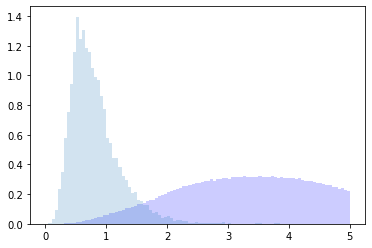

In [64]:
bins = np.linspace(0,5,101)
#plt.ylim((0,250))
plt.hist(sig2loss_rndbkg, color='b', density= True,bins = bins,alpha = 0.2);

#plt.hist(bkgloss_prong2, density= True,bins = bins,alpha = 0.2);
plt.hist(sigae2_loss_list[1],density= True,bins = bins,alpha = 0.2);
#plt.hist(bkgae_loss_list[1],density= True,bins = bins,alpha = 0.2);
#plt.hist(bkgae_loss_list[2],density= True,bins = bins,alpha = 0.2);
#plt.hist(bkgae_loss_list[3],density= True,bins = bins,alpha = 0.2);


In [65]:
from scipy.spatial import ConvexHull

def get_hull_coordinates(scan_tpr, scan_fpr):
    points = np.array([scan_fpr,scan_tpr])
    points = points.transpose()
    hull = ConvexHull(points)
    fpr = np.array(points[hull.vertices[:],0])
    tpr = np.array(points[hull.vertices[:],1])
    nonzero_idx = np.nonzero(fpr)
    fpr = fpr[nonzero_idx]
    tpr = tpr[nonzero_idx]
    return tpr, fpr 


In [86]:
def get_tpr_fpr_2d(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss):
    bins_bkgae = np.arange(0,10,.5)
    bins_sigae = np.arange(0,15,0.07)
    tpr = []
    fpr = []
    for sigcut in bins_sigae:
        for bkgcut in bins_bkgae:
            tpr_t = np.where((sigae_sigloss<sigcut)&(bkgae_sigloss>bkgcut))[0].shape[0]/len(sigae_sigloss)
            fpr_t = np.where((sigae_bkgloss<sigcut)&(bkgae_bkgloss>bkgcut))[0].shape[0]/len(sigae_bkgloss)
            tpr.append(tpr_t)
            fpr.append(fpr_t)
            
    tpr, fpr = get_hull_coordinates(tpr, fpr)
                

    return tpr,fpr


In [87]:
def get_tpr_fpr_3d(sigae_sigloss,sigae_bkgloss,sigae2_sigloss,sigae2_bkgloss,bkgae_sigloss,bkgae_bkgloss):
    bins_bkgae = np.arange(0,10,.05)
    bins_sigae = np.arange(0,15,.07)
    bins_sigae2 = np.arange(0,7,.07)
    tpr = []
    fpr = []
    for sigcut in bins_sigae:
        for sigcut2 in bins_sigae2:
            for bkgcut in bins_bkgae:
                tpr_t = np.where((sigae2_sigloss<sigcut2)&(sigae_sigloss<sigcut)&(bkgae_sigloss>bkgcut))[0].shape[0]/len(sigae_sigloss)
                fpr_t = np.where((sigae2_bkgloss<sigcut2)&(sigae_bkgloss<sigcut)&(bkgae_bkgloss>bkgcut))[0].shape[0]/len(sigae_bkgloss)
                tpr.append(tpr_t)
                fpr.append(fpr_t)
            
    tpr, fpr = get_hull_coordinates(tpr, fpr)
                

    return tpr,fpr

In [88]:
def get_tpr_fpr_bkg(sigloss,bkgloss):
    bins = np.arange(0.,100,.01)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))

    return tpr,fpr

In [89]:
tprlistbkgaej1mass = []
fprlistbkgaej1mass = []
fprinverselistbkgaej1mass = []
tprlistbkgaej1mass_forinverse = []

bkgref_tpr, bkgref_fpr = get_tpr_fpr_bkg(bkgloss_prong2,bkgloss_rndbkg)
bkgref_tpr_np, bkgref_fpr_np = np.array(bkgref_tpr), np.array(bkgref_fpr)
nonzero_idx = np.nonzero(bkgref_fpr_np)
bkgref_tpr_inv = bkgref_tpr_np[nonzero_idx]
bkgref_fpr_inv = 1/bkgref_fpr_np[nonzero_idx]


for a in bkgae_loss_list:
    tpr, fpr = get_tpr_fpr_bkg(a,bkgloss_rndbkg)
    #print()
    tprlistbkgaej1mass.append(tpr)
    fprlistbkgaej1mass.append(fpr)
    fpr_np = np.array(fpr)
    tpr_np = np.array(tpr)
    nonzero_idx = np.nonzero(fpr_np)
    tprlistbkgaej1mass_forinverse.append(tpr_np[nonzero_idx])
    fprinverselistbkgaej1mass.append(1/fpr_np[nonzero_idx])
    #print(fpr)
    #fprinverselistbkgaej1mass.append(1/fpr_np)

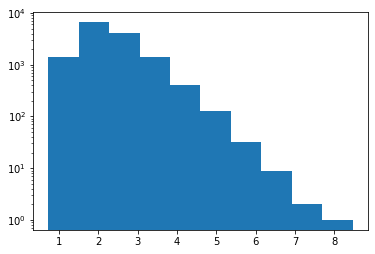

In [90]:
plt.hist(sigae_loss_list[0])
plt.yscale('log')

In [91]:
tprlistscanj1mass = []
fprlistscanj1mass = []
fprinverselistscanj1mass = []
tprlistscanj1mass_forinverse = []

tprlistscanj1mass_3d = []
fprlistscanj1mass_3d = []
fprinverselistscanj1mass_3d = []
tprlistscanj1mass_forinverse_3d = []

scanref_tpr, scanref_fpr = get_tpr_fpr_2d(sigloss_prong2,sigloss_rndbkg,bkgloss_prong2,bkgloss_rndbkg)
scanref_tpr_3d, scanref_fpr_3d = get_tpr_fpr_3d(sigloss_prong2,sigloss_rndbkg,sig2loss_prong2,sig2loss_rndbkg,bkgloss_prong2,bkgloss_rndbkg)


scanref_tpr_inv = scanref_tpr
scanref_fpr_inv = 1/scanref_fpr

scanref_tpr_3d_inv = scanref_tpr_3d
scanref_fpr_3d_inv = 1/scanref_fpr_3d


for a,b,c in zip(sigae_loss_list,bkgae_loss_list,sigae2_loss_list):
    tpr, fpr = get_tpr_fpr_2d(a,sigloss_rndbkg, b, bkgloss_rndbkg)
    tpr_3d, fpr_3d = get_tpr_fpr_3d(a,sigloss_rndbkg,c, sig2loss_rndbkg,b, bkgloss_rndbkg)
    #print()
    tprlistscanj1mass.append(tpr)
    fprlistscanj1mass.append(fpr)
    tprlistscanj1mass_3d.append(tpr_3d)
    fprlistscanj1mass_3d.append(fpr_3d)

    tprlistscanj1mass_forinverse.append(tpr)
    fprinverselistscanj1mass.append(1/fpr)
    tprlistscanj1mass_forinverse_3d.append(tpr_3d)
    fprinverselistscanj1mass_3d.append(1/fpr_3d)
    #print(fpr)
    #fprinverselistbkgaej1mass.append(1/fpr_np)

In [107]:
#plt.plot(scanref_tpr_3d_inv,scanref_fpr_3d_inv,label='2prong 4500 500 150 (correct),3d')
#plt.plot(tprlistscanj1mass_forinverse_3d[1][1:],fprinverselistscanj1mass_3d[1][1:],label='2prong 4500 700 150,3d')
#plt.plot(tprlistscanj1mass_forinverse_3d[2][:-4],fprinverselistscanj1mass_3d[2][:-4],label='2prong 4500 500 300,3d')
#plt.plot(tprlistscanj1mass_forinverse_3d[3][:-5],fprinverselistscanj1mass_3d[3][:-5],label='2prong 4500 700 300,3d')
plt.plot(tprlistscanj1mass_forinverse_3d[4][1:-3],fprinverselistscanj1mass_3d[4][1:-3],label='2prong 6000 700 150,3d',color='r')
plt.plot(tprlistscanj1mass_forinverse_3d[5][:-3],fprinverselistscanj1mass_3d[5][:-3],label='2prong 6000 500 300,3d',color='g')
plt.plot(tprlistscanj1mass_forinverse_3d[6][1:-4],fprinverselistscanj1mass_3d[6][1:-4],label='2prong 6000 700 300,3d',color='b')

#plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='2prong 4500 500 150 (correct)',linestyle='dashed')
#plt.plot(tprlistscanj1mass_forinverse[1][1:],fprinverselistscanj1mass[1][1:],label='2prong 4500 700 150',linestyle='dashed')
#plt.plot(tprlistscanj1mass_forinverse[2][:-4],fprinverselistscanj1mass[2][:-4],label='2prong 4500 500 300',linestyle='dashed')
#plt.plot(tprlistscanj1mass_forinverse[3][:-5],fprinverselistscanj1mass[3][:-5],label='2prong 4500 700 300',linestyle='dashed')
plt.plot(tprlistscanj1mass_forinverse[4][1:-3],fprinverselistscanj1mass[4][1:-3],label='2prong 6000 700 150',linestyle='dashed',color='r')
plt.plot(tprlistscanj1mass_forinverse[5][:-3],fprinverselistscanj1mass[5][:-3],label='2prong 6000 500 300',linestyle='dashed',color='g')
plt.plot(tprlistscanj1mass_forinverse[6][1:-4],fprinverselistscanj1mass[6][1:-4],label='2prong 6000 700 300',linestyle='dashed',color='b')

#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

IndexError: list index out of range

In [86]:
plt.plot(sup_fpr,sup_tpr,label='mjj 3500 j1mass 500')
#plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
#plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
plt.plot(fprlistsupj1mass[0],tprlistsupj1mass[0],label='j1mass 150')
plt.plot(fprlistsupj1mass[1],tprlistsupj1mass[1],label='j1mass 300')
plt.plot(fprlistsupj1mass[2],tprlistsupj1mass[2],label='j1mass 450')
plt.plot(fprlistsupj1mass[3],tprlistsupj1mass[3],label='j1mass 500')
#plt.plot(fprlistsupj1mass[4],tprlistsupj1mass[4],label='j1mass 650')
#plt.plot(fprlistsupj1mass[5],tprlistsupj1mass[5],label='j1mass 700')



#plt.plot(fprlistj1mass[6],tprlistj1mass[6],label='j1mass 850')
#plt.plot(fprlistj1mass[7],tprlistj1mass[7],label='j1mass 900')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

NameError: name 'sup_fpr' is not defined

(0.0, 1.0)

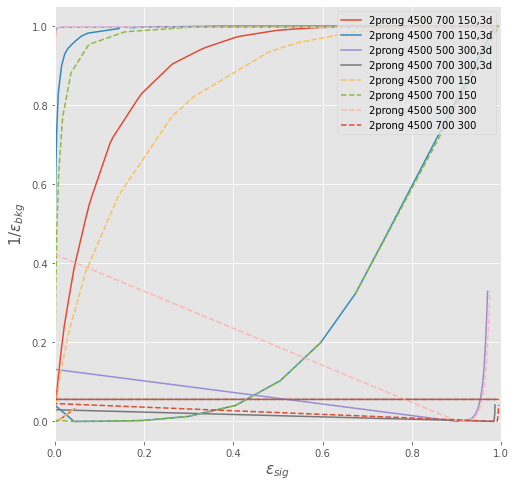

In [87]:
#plt.plot(scanref_tpr_3d_inv,scanref_fpr_3d_inv,label='2prong 4500 500 150 (correct),3d')
plt.plot(fprlistscanj1mass_3d[0][:],tprlistscanj1mass_3d[0][:],label='2prong 4500 700 150,3d')
plt.plot(fprlistscanj1mass_3d[1][:],tprlistscanj1mass_3d[1][:],label='2prong 4500 700 150,3d')
plt.plot(fprlistscanj1mass_3d[2][:],tprlistscanj1mass_3d[2][:],label='2prong 4500 500 300,3d')
plt.plot(fprlistscanj1mass_3d[3][:],tprlistscanj1mass_3d[3][:],label='2prong 4500 700 300,3d')
#plt.plot(tprlistscanj1mass_forinverse_3d[4][1:-3],fprinverselistscanj1mass_3d[4][1:-3],label='2prong 6000 700 150,3d',color='r')
#plt.plot(tprlistscanj1mass_forinverse_3d[5][:-3],fprinverselistscanj1mass_3d[5][:-3],label='2prong 6000 500 300,3d',color='g')
#plt.plot(tprlistscanj1mass_forinverse_3d[6][1:-4],fprinverselistscanj1mass_3d[6][1:-4],label='2prong 6000 700 300,3d',color='b')

#plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='2prong 4500 500 150 (correct)',linestyle='dashed')
plt.plot(fprlistscanj1mass[0][:],tprlistscanj1mass[0][:],label='2prong 4500 700 150',linestyle='dashed')
plt.plot(fprlistscanj1mass[1][:],tprlistscanj1mass[1][:],label='2prong 4500 700 150',linestyle='dashed')
plt.plot(fprlistscanj1mass[2][:],tprlistscanj1mass[2][:],label='2prong 4500 500 300',linestyle='dashed')
plt.plot(fprlistscanj1mass[3][:],tprlistscanj1mass[3][:],label='2prong 4500 700 300',linestyle='dashed')
#plt.plot(tprlistscanj1mass_forinverse[4][1:-3],fprinverselistscanj1mass[4][1:-3],label='2prong 6000 700 150',linestyle='dashed',color='r')
#plt.plot(tprlistscanj1mass_forinverse[5][:-3],fprinverselistscanj1mass[5][:-3],label='2prong 6000 500 300',linestyle='dashed',color='g')
#plt.plot(tprlistscanj1mass_forinverse[6][1:-4],fprinverselistscanj1mass[6][1:-4],label='2prong 6000 700 300',linestyle='dashed',color='b')

#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

#plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

In [91]:
threeprong_wps = ([4500,300,300],[5000,500,500],[5500,700,700],[6000, 900, 900])

In [93]:
plt.rcParams["figure.figsize"] = (8,8)
plt.style.use('ggplot')

In [94]:
threeprong_wps

([4500, 300, 300], [5000, 500, 500], [5500, 700, 700], [6000, 900, 900])

In [ ]:
np.save()

(0.0, 1.0)

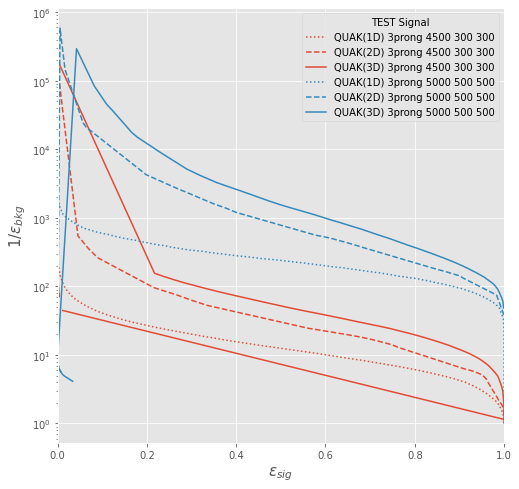

In [97]:
#plt.plot(scanref_tpr_3d_inv,scanref_fpr_3d_inv,label='2prong 4500 500 150 (correct),3d')
plt.plot(tprlistbkgaej1mass_forinverse[0][:-1],fprinverselistbkgaej1mass[0][:-1],color='C0',label='QUAK(1D) 3prong 4500 300 300',linestyle='dotted')
plt.plot(tprlistscanj1mass_forinverse[0][:-1],fprinverselistscanj1mass[0][:-1],color='C0',label='QUAK(2D) 3prong 4500 300 300',linestyle='dashed')
plt.plot(tprlistscanj1mass_forinverse_3d[0][:-1],fprinverselistscanj1mass_3d[0][:-1],color='C0',label='QUAK(3D) 3prong 4500 300 300')


plt.plot(tprlistbkgaej1mass_forinverse[1][3:-7],fprinverselistbkgaej1mass[1][3:-7],color='C1',label='QUAK(1D) 3prong 5000 500 500',linestyle='dotted')
plt.plot(tprlistscanj1mass_forinverse[1][2:-8],fprinverselistscanj1mass[1][2:-8],color='C1',label='QUAK(2D) 3prong 5000 500 500',linestyle='dashed')
plt.plot(tprlistscanj1mass_forinverse_3d[1][3:-8],fprinverselistscanj1mass_3d[1][3:-8],color='C1',label='QUAK(3D) 3prong 5000 500 500')
#plt.plot(tprlistscanj1mass_forinverse_3d[2][:],fprinverselistscanj1mass_3d[2][:],label='2prong 4500 500 300,3d')
#plt.plot(tprlistscanj1mass_forinverse_3d[3][:],fprinverselistscanj1mass_3d[3][:],label='2prong 4500 700 300,3d')
#plt.plot(tprlistscanj1mass_forinverse_3d[4][1:-3],fprinverselistscanj1mass_3d[4][1:-3],label='2prong 6000 700 150,3d',color='r')
#plt.plot(tprlistscanj1mass_forinverse_3d[5][:-3],fprinverselistscanj1mass_3d[5][:-3],label='2prong 6000 500 300,3d',color='g')
#plt.plot(tprlistscanj1mass_forinverse_3d[6][1:-4],fprinverselistscanj1mass_3d[6][1:-4],label='2prong 6000 700 300,3d',color='b')

#plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='2prong 4500 500 150 (correct)',linestyle='dashed')
#plt.plot(tprlistscanj1mass_forinverse[2][:],fprinverselistscanj1mass[2][:],label='2prong 4500 500 300',linestyle='dashed')
#plt.plot(tprlistscanj1mass_forinverse[3][:],fprinverselistscanj1mass[3][:],label='2prong 4500 700 300',linestyle='dashed')
#plt.plot(tprlistscanj1mass_forinverse[4][1:-3],fprinverselistscanj1mass[4][1:-3],label='2prong 6000 700 150',linestyle='dashed',color='r')
#plt.plot(tprlistscanj1mass_forinverse[5][:-3],fprinverselistscanj1mass[5][:-3],label='2prong 6000 500 300',linestyle='dashed',color='g')
#plt.plot(tprlistscanj1mass_forinverse[6][1:-4],fprinverselistscanj1mass[6][1:-4],label='2prong 6000 700 300',linestyle='dashed',color='b')

#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right',prop={'size': 10},title='TEST Signal')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

In [81]:
varyjetmass_wps

([4500, 500, 150],
 [4500, 700, 150],
 [4500, 500, 300],
 [4500, 700, 300],
 [6000, 700, 150],
 [6000, 500, 300],
 [6000, 700, 300])

(0.0, 1.0)

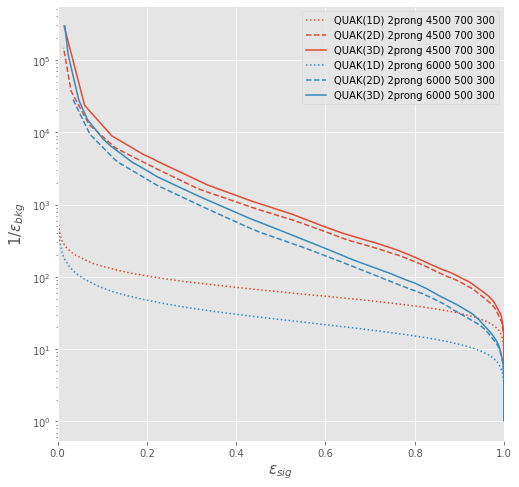

In [99]:
#plt.plot(scanref_tpr_3d_inv,scanref_fpr_3d_inv,label='2prong 4500 500 150 (correct),3d')
#plt.plot(tprlistscanj1mass_forinverse_3d[1][1:],fprinverselistscanj1mass_3d[1][1:],label='2prong 4500 700 150,3d')
#plt.plot(tprlistscanj1mass_forinverse_3d[2][:-4],fprinverselistscanj1mass_3d[2][:-4],label='2prong 4500 500 300,3d')
#plt.plot(tprlistscanj1mass_forinverse_3d[4][1:-3],fprinverselistscanj1mass_3d[4][1:-3],label='2prong 6000 700 150,3d',color='r')

plt.plot(tprlistbkgaej1mass_forinverse[3][:],fprinverselistbkgaej1mass[3][:],label='QUAK(1D) 2prong 4500 700 300',linestyle='dotted',color='C0')

plt.plot(tprlistscanj1mass_forinverse[3][1:-2],fprinverselistscanj1mass[3][1:-2],label='QUAK(2D) 2prong 4500 700 300',linestyle='dashed',color='C0')

plt.plot(tprlistscanj1mass_forinverse_3d[3][1:-2],fprinverselistscanj1mass_3d[3][1:-2],label='QUAK(3D) 2prong 4500 700 300',color='C0')

plt.plot(tprlistbkgaej1mass_forinverse[5][:-3],fprinverselistbkgaej1mass[5][:-3],label='QUAK(1D) 2prong 6000 500 300',linestyle='dotted',color='C1')

plt.plot(tprlistscanj1mass_forinverse[5][1:-3],fprinverselistscanj1mass[5][1:-3],label='QUAK(2D) 2prong 6000 500 300',linestyle='dashed',color='C1')

plt.plot(tprlistscanj1mass_forinverse_3d[5][1:-3],fprinverselistscanj1mass_3d[5][1:-3],label='QUAK(3D) 2prong 6000 500 300',color='C1')
#plt.plot(tprlistscanj1mass_forinverse_3d[6][1:-4],fprinverselistscanj1mass_3d[6][1:-4],label='2prong 6000 700 300,3d',color='b')

#plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='2prong 4500 500 150 (correct)',linestyle='dashed')
#plt.plot(tprlistscanj1mass_forinverse[1][1:],fprinverselistscanj1mass[1][1:],label='2prong 4500 700 150',linestyle='dashed')
#plt.plot(tprlistscanj1mass_forinverse[2][:-4],fprinverselistscanj1mass[2][:-4],label='2prong 4500 500 300',linestyle='dashed')
#plt.plot(tprlistscanj1mass_forinverse[4][1:-3],fprinverselistscanj1mass[4][1:-3],label='2prong 6000 700 150',linestyle='dashed',color='r')
#plt.plot(tprlistscanj1mass_forinverse[6][1:-4],fprinverselistscanj1mass[6][1:-4],label='2prong 6000 700 300',linestyle='dashed',color='b')

#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

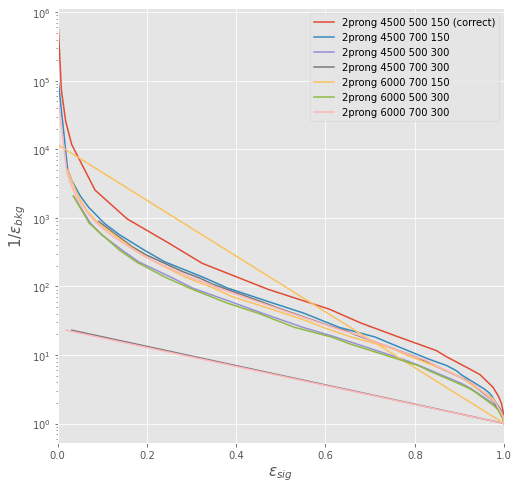

In [116]:
plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='2prong 4500 500 150 (correct)')
plt.plot(tprlistscanj1mass_forinverse[1][1:],fprinverselistscanj1mass[1][1:],label='2prong 4500 700 150')
plt.plot(tprlistscanj1mass_forinverse[2][:-4],fprinverselistscanj1mass[2][:-4],label='2prong 4500 500 300')
plt.plot(tprlistscanj1mass_forinverse[3][:-5],fprinverselistscanj1mass[3][:-5],label='2prong 4500 700 300')
plt.plot(tprlistscanj1mass_forinverse[4][:-3],fprinverselistscanj1mass[4][:-3],label='2prong 6000 700 150')
plt.plot(tprlistscanj1mass_forinverse[5][:-3],fprinverselistscanj1mass[5][:-3],label='2prong 6000 500 300')
plt.plot(tprlistscanj1mass_forinverse[6][:-4],fprinverselistscanj1mass[6][:-4],label='2prong 6000 700 300')


#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

In [80]:
#supervised_loss_list, sigae_loss_list, bkgae_loss_list = [], [], []
#for mjj, j1mass, j2mass in threeprong_wps:
#    supervised_loss, sigae_loss, bkgae_loss = get_loss_from_priors('3prong', mjj, j1mass, j2mass)
#    supervised_loss_list.append(supervised_loss)    
#    sigae_loss_list.append(sigae_loss)
#    bkgae_loss_list.append(bkgae_loss)

In [165]:
tprlistsupj1mass = []
fprlistsupj1mass = []
tprlistsupj1mass_forinverse = []
fprinverselistsupj1mass = []

sup_tpr, sup_fpr = get_tpr_fpr(sigscore,bkgscore)
sup_tpr_np, sup_fpr_np = np.array(sup_tpr), np.array(sup_fpr)
nonzero_idx = np.nonzero(sup_fpr_np)
sup_tpr_inv = sup_tpr_np[nonzero_idx]
sup_fpr_inv = 1/sup_fpr_np[nonzero_idx]
for a in supervised_loss_list:
    #print(a)
    tpr, fpr = get_tpr_fpr(a,bkgscore)
    tprlistsupj1mass.append(tpr)
    fprlistsupj1mass.append(fpr)
    fpr_np = np.array(fpr)
    tpr_np = np.array(tpr)
    nonzero_idx = np.nonzero(fpr_np)
    tprlistsupj1mass_forinverse.append(tpr_np[nonzero_idx])
    fprinverselistsupj1mass.append(1/fpr_np[nonzero_idx])

In [114]:
plt.rcParams["figure.figsize"] = (8,8)


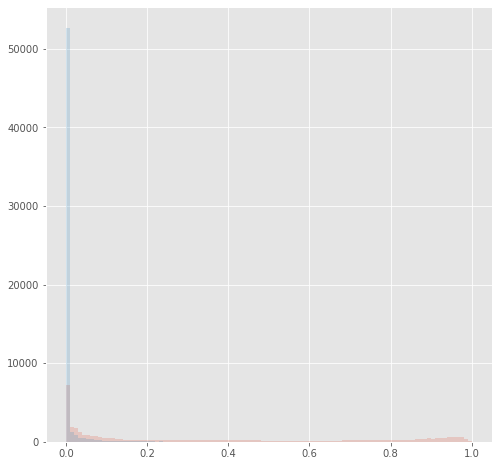

In [167]:
bins = np.linspace(0,1,101)
#plt.ylim((0,250))
plt.hist(supervised_loss_list[2],bins = bins,alpha = 0.2);
plt.hist(bkgscore, bins = bins,alpha = 0.2);

In [168]:
varyjetmass_wps

([4500, 500, 150],
 [4500, 700, 150],
 [4500, 500, 300],
 [4500, 700, 300],
 [6000, 700, 150],
 [6000, 500, 300],
 [6000, 700, 300])

(0.0, 1.0)

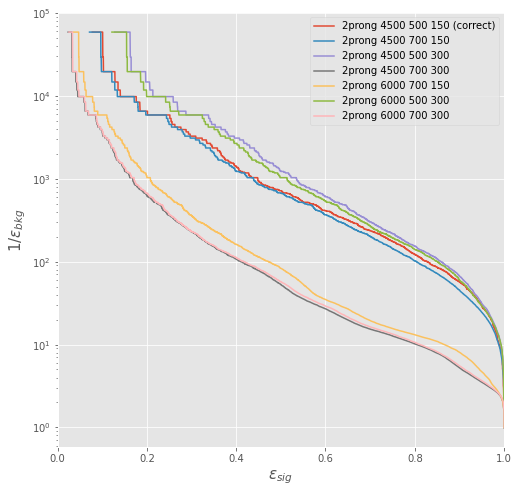

In [169]:
######threeprong
plt.plot(sup_tpr_inv,sup_fpr_inv,label='2prong 4500 500 150 (correct)')
#threeprong_wps = ([4500,300,300],[5000,500,500],[5500,700,700],[6000, 900, 900])

plt.plot(tprlistsupj1mass_forinverse[0],fprinverselistsupj1mass[0],label='2prong 4500 700 150')
plt.plot(tprlistsupj1mass_forinverse[1],fprinverselistsupj1mass[1],label='2prong 4500 500 300')
plt.plot(tprlistsupj1mass_forinverse[2],fprinverselistsupj1mass[2],label='2prong 4500 700 300')


plt.plot(tprlistsupj1mass_forinverse[3],fprinverselistsupj1mass[3],label='2prong 6000 700 150')
plt.plot(tprlistsupj1mass_forinverse[4],fprinverselistsupj1mass[4],label='2prong 6000 500 300')
plt.plot(tprlistsupj1mass_forinverse[5],fprinverselistsupj1mass[5],label='2prong 6000 700 300')

#plt.plot(tprlistsupj1mass_forinverse[4],fprinverselistsupj1mass[4],label='mjj 4000 j1mass 650')
#plt.plot(tprlistsupj1mass_forinverse[5],fprinverselistsupj1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

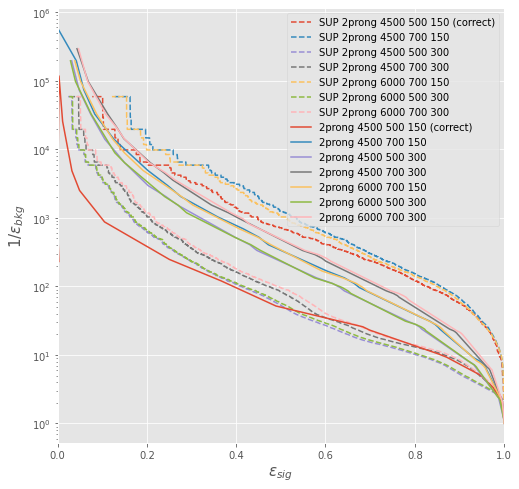

In [127]:
plt.plot(sup_tpr_inv,sup_fpr_inv,linestyle='dashed',label='SUP 2prong 4500 500 150 (correct)')

plt.plot(tprlistsupj1mass_forinverse[0],fprinverselistsupj1mass[0],linestyle='dashed',label='SUP 2prong 4500 700 150')
plt.plot(tprlistsupj1mass_forinverse[1],fprinverselistsupj1mass[1],linestyle='dashed',label='SUP 2prong 4500 500 300')
plt.plot(tprlistsupj1mass_forinverse[2],fprinverselistsupj1mass[2],linestyle='dashed',label='SUP 2prong 4500 700 300')


plt.plot(tprlistsupj1mass_forinverse[3],fprinverselistsupj1mass[3],linestyle='dashed',label='SUP 2prong 6000 700 150')
plt.plot(tprlistsupj1mass_forinverse[4],fprinverselistsupj1mass[4],linestyle='dashed',label='SUP 2prong 6000 500 300')
plt.plot(tprlistsupj1mass_forinverse[5],fprinverselistsupj1mass[5],linestyle='dashed',label='SUP 2prong 6000 700 300')

plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='2prong 4500 500 150 (correct)')
plt.plot(tprlistscanj1mass_forinverse[0][1:],fprinverselistscanj1mass[0][1:],label='2prong 4500 700 150')
plt.plot(tprlistscanj1mass_forinverse[1][:-4],fprinverselistscanj1mass[1][:-4],label='2prong 4500 500 300')
plt.plot(tprlistscanj1mass_forinverse[2][:-5],fprinverselistscanj1mass[2][:-5],label='2prong 4500 700 300')
plt.plot(tprlistscanj1mass_forinverse[3][:-3],fprinverselistscanj1mass[3][:-3],label='2prong 6000 700 150')
plt.plot(tprlistscanj1mass_forinverse[4][:-3],fprinverselistscanj1mass[4][:-3],label='2prong 6000 500 300')
plt.plot(tprlistscanj1mass_forinverse[5][:-4],fprinverselistscanj1mass[5][:-4],label='2prong 6000 700 300')


#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

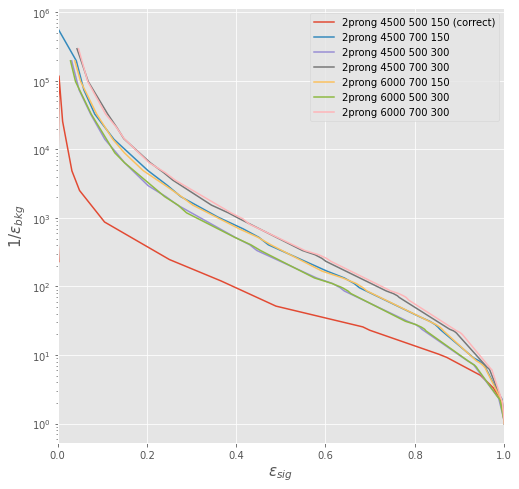

In [126]:
plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='2prong 4500 500 150 (correct)')
plt.plot(tprlistscanj1mass_forinverse[0][1:],fprinverselistscanj1mass[0][1:],label='2prong 4500 700 150')
plt.plot(tprlistscanj1mass_forinverse[1][:-4],fprinverselistscanj1mass[1][:-4],label='2prong 4500 500 300')
plt.plot(tprlistscanj1mass_forinverse[2][:-5],fprinverselistscanj1mass[2][:-5],label='2prong 4500 700 300')
plt.plot(tprlistscanj1mass_forinverse[3][:-3],fprinverselistscanj1mass[3][:-3],label='2prong 6000 700 150')
plt.plot(tprlistscanj1mass_forinverse[4][:-3],fprinverselistscanj1mass[4][:-3],label='2prong 6000 500 300')
plt.plot(tprlistscanj1mass_forinverse[5][:-4],fprinverselistscanj1mass[5][:-4],label='2prong 6000 700 300')


#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

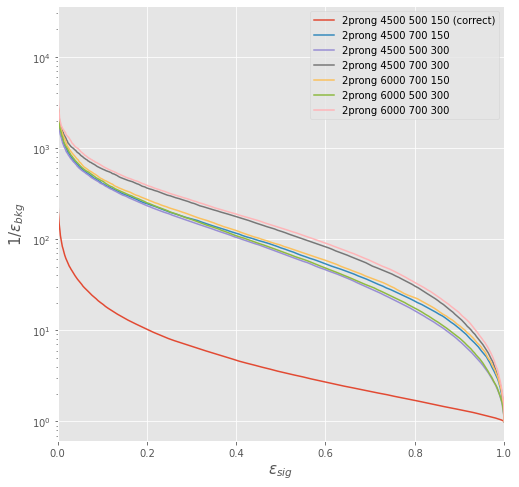

In [68]:
plt.plot(bkgref_tpr_inv,bkgref_fpr_inv,label='2prong 4500 500 150 (correct)')
plt.plot(tprlistbkgaej1mass_forinverse[0],fprinverselistbkgaej1mass[0],label='2prong 4500 700 150')
plt.plot(tprlistbkgaej1mass_forinverse[1],fprinverselistbkgaej1mass[1],label='2prong 4500 500 300')
plt.plot(tprlistbkgaej1mass_forinverse[2],fprinverselistbkgaej1mass[2],label='2prong 4500 700 300')
plt.plot(tprlistbkgaej1mass_forinverse[3],fprinverselistbkgaej1mass[3],label='2prong 6000 700 150')

plt.plot(tprlistbkgaej1mass_forinverse[4],fprinverselistbkgaej1mass[4],label='2prong 6000 500 300')
plt.plot(tprlistbkgaej1mass_forinverse[5],fprinverselistbkgaej1mass[5],label='2prong 6000 700 300')
#label='3prong 4500 300 300'
#label='3prong 5000 500 500'
#label='3prong 5500 700 700'
#label='3prong 6000 900 900'
#plt.plot(tprlistbkgaej1mass_forinverse[4],fprinverselistbkgaej1mass[4],label='mjj 4000 j1mass 650')
#plt.plot(tprlistbkgaej1mass_forinverse[5],fprinverselistbkgaej1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

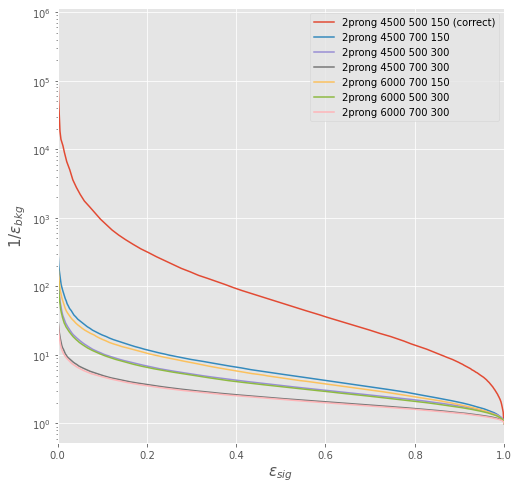

In [69]:
plt.plot(sigref_tpr_inv,sigref_fpr_inv,label='2prong 4500 500 150 (correct)')
plt.plot(tprlistsigaej1mass_forinverse[0],fprinverselistsigaej1mass[0],label='2prong 4500 700 150')
plt.plot(tprlistsigaej1mass_forinverse[1],fprinverselistsigaej1mass[1],label='2prong 4500 500 300')
plt.plot(tprlistsigaej1mass_forinverse[2],fprinverselistsigaej1mass[2],label='2prong 4500 700 300')
plt.plot(tprlistsigaej1mass_forinverse[3],fprinverselistsigaej1mass[3],label='2prong 6000 700 150')


plt.plot(tprlistsigaej1mass_forinverse[4],fprinverselistsigaej1mass[4],label='2prong 6000 500 300')
plt.plot(tprlistsigaej1mass_forinverse[5],fprinverselistsigaej1mass[5],label='2prong 6000 700 300')


#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

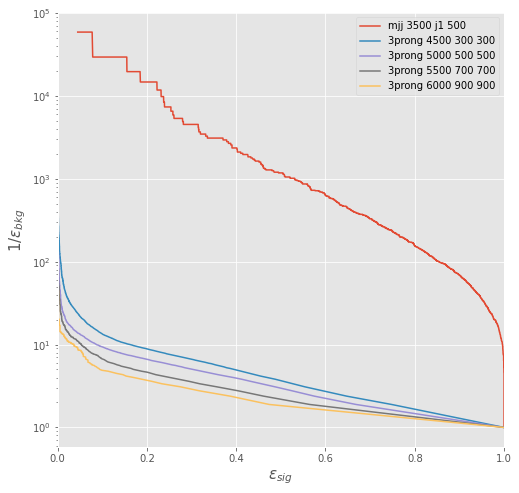

In [63]:
######threeprong
plt.plot(sup_tpr_inv,sup_fpr_inv,label='mjj 3500 j1 500')
threeprong_wps = ([4500,300,300],[5000,500,500],[5500,700,700],[6000, 900, 900])

plt.plot(tprlistsupj1mass_forinverse[0],fprinverselistsupj1mass[0],label='3prong 4500 300 300')
plt.plot(tprlistsupj1mass_forinverse[1],fprinverselistsupj1mass[1],label='3prong 5000 500 500')
plt.plot(tprlistsupj1mass_forinverse[2],fprinverselistsupj1mass[2],label='3prong 5500 700 700')
plt.plot(tprlistsupj1mass_forinverse[3],fprinverselistsupj1mass[3],label='3prong 6000 900 900')
#plt.plot(tprlistsupj1mass_forinverse[4],fprinverselistsupj1mass[4],label='mjj 4000 j1mass 650')
#plt.plot(tprlistsupj1mass_forinverse[5],fprinverselistsupj1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

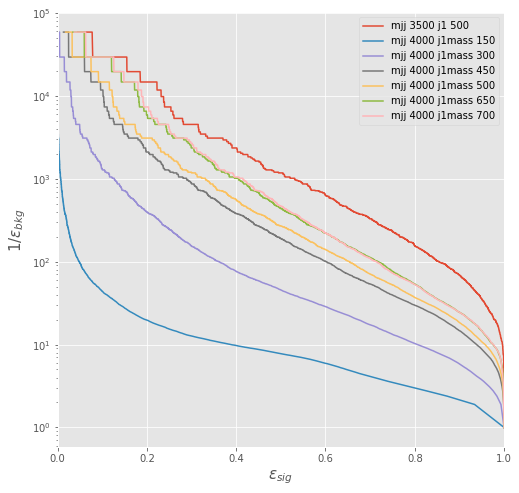

In [63]:
plt.plot(sup_tpr_inv,sup_fpr_inv,label='mjj 3500 j1 500')
plt.plot(tprlistsupj1mass_forinverse[0],fprinverselistsupj1mass[0],label='mjj 4000 j1mass 150')
plt.plot(tprlistsupj1mass_forinverse[1],fprinverselistsupj1mass[1],label='mjj 4000 j1mass 300')
plt.plot(tprlistsupj1mass_forinverse[2],fprinverselistsupj1mass[2],label='mjj 4000 j1mass 450')
plt.plot(tprlistsupj1mass_forinverse[3],fprinverselistsupj1mass[3],label='mjj 4000 j1mass 500')
plt.plot(tprlistsupj1mass_forinverse[4],fprinverselistsupj1mass[4],label='mjj 4000 j1mass 650')
plt.plot(tprlistsupj1mass_forinverse[5],fprinverselistsupj1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

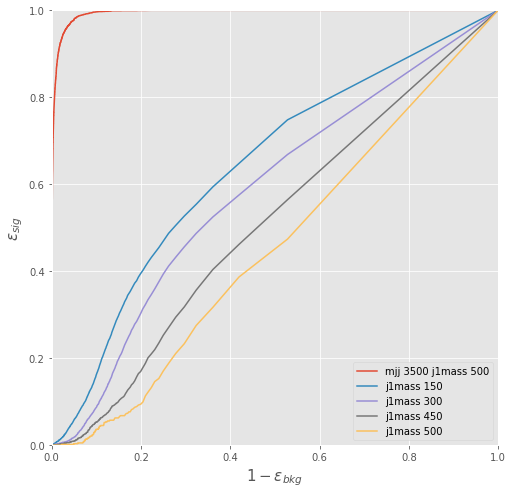

In [64]:
plt.plot(sup_fpr,sup_tpr,label='mjj 3500 j1mass 500')
#plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
#plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
plt.plot(fprlistsupj1mass[0],tprlistsupj1mass[0],label='j1mass 150')
plt.plot(fprlistsupj1mass[1],tprlistsupj1mass[1],label='j1mass 300')
plt.plot(fprlistsupj1mass[2],tprlistsupj1mass[2],label='j1mass 450')
plt.plot(fprlistsupj1mass[3],tprlistsupj1mass[3],label='j1mass 500')
#plt.plot(fprlistsupj1mass[4],tprlistsupj1mass[4],label='j1mass 650')
#plt.plot(fprlistsupj1mass[5],tprlistsupj1mass[5],label='j1mass 700')



#plt.plot(fprlistj1mass[6],tprlistj1mass[6],label='j1mass 850')
#plt.plot(fprlistj1mass[7],tprlistj1mass[7],label='j1mass 900')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

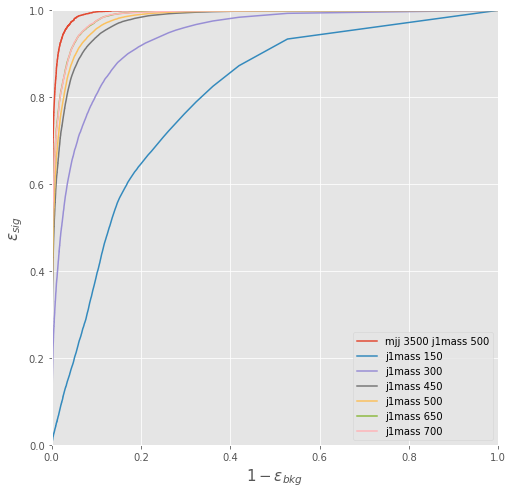

In [64]:
plt.plot(sup_fpr,sup_tpr,label='mjj 3500 j1mass 500')
#plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
#plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
plt.plot(fprlistsupj1mass[0],tprlistsupj1mass[0],label='j1mass 150')
plt.plot(fprlistsupj1mass[1],tprlistsupj1mass[1],label='j1mass 300')
plt.plot(fprlistsupj1mass[2],tprlistsupj1mass[2],label='j1mass 450')
plt.plot(fprlistsupj1mass[3],tprlistsupj1mass[3],label='j1mass 500')
plt.plot(fprlistsupj1mass[4],tprlistsupj1mass[4],label='j1mass 650')
plt.plot(fprlistsupj1mass[5],tprlistsupj1mass[5],label='j1mass 700')



#plt.plot(fprlistj1mass[6],tprlistj1mass[6],label='j1mass 850')
#plt.plot(fprlistj1mass[7],tprlistj1mass[7],label='j1mass 900')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

In [170]:
tprlistbkgaej1mass = []
fprlistbkgaej1mass = []
fprinverselistbkgaej1mass = []
tprlistbkgaej1mass_forinverse = []

bkgref_tpr, bkgref_fpr = get_tpr_fpr_bkg(bkgloss_prong2,bkgloss_rndbkg)
bkgref_tpr_np, bkgref_fpr_np = np.array(bkgref_tpr), np.array(bkgref_fpr)
nonzero_idx = np.nonzero(bkgref_fpr_np)
bkgref_tpr_inv = bkgref_tpr_np[nonzero_idx]
bkgref_fpr_inv = 1/bkgref_fpr_np[nonzero_idx]


for a in bkgae_loss_list:
    tpr, fpr = get_tpr_fpr_bkg(a,bkgloss_rndbkg)
    #print()
    tprlistbkgaej1mass.append(tpr)
    fprlistbkgaej1mass.append(fpr)
    fpr_np = np.array(fpr)
    tpr_np = np.array(tpr)
    nonzero_idx = np.nonzero(fpr_np)
    tprlistbkgaej1mass_forinverse.append(tpr_np[nonzero_idx])
    fprinverselistbkgaej1mass.append(1/fpr_np[nonzero_idx])
    #print(fpr)
    #fprinverselistbkgaej1mass.append(1/fpr_np)

(0.0, 1.0)

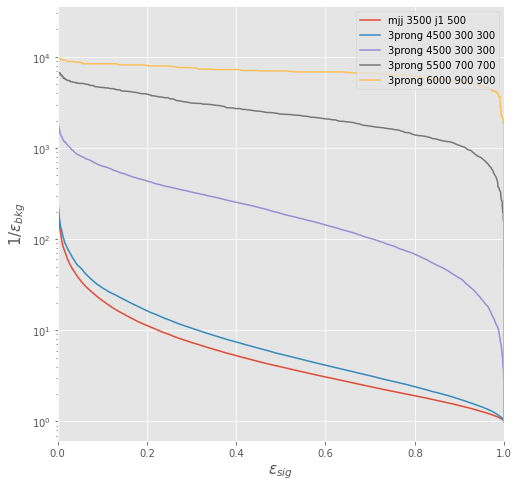

In [67]:
plt.plot(bkgref_tpr_inv,bkgref_fpr_inv,label='mjj 3500 j1 500')
plt.plot(tprlistbkgaej1mass_forinverse[0],fprinverselistbkgaej1mass[0],label='3prong 4500 300 300')
plt.plot(tprlistbkgaej1mass_forinverse[1],fprinverselistbkgaej1mass[1],label='3prong 4500 300 300')
plt.plot(tprlistbkgaej1mass_forinverse[2],fprinverselistbkgaej1mass[2],label='3prong 5500 700 700')
plt.plot(tprlistbkgaej1mass_forinverse[3],fprinverselistbkgaej1mass[3],label='3prong 6000 900 900')
#label='3prong 4500 300 300'
#label='3prong 5000 500 500'
#label='3prong 5500 700 700'
#label='3prong 6000 900 900'
#plt.plot(tprlistbkgaej1mass_forinverse[4],fprinverselistbkgaej1mass[4],label='mjj 4000 j1mass 650')
#plt.plot(tprlistbkgaej1mass_forinverse[5],fprinverselistbkgaej1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

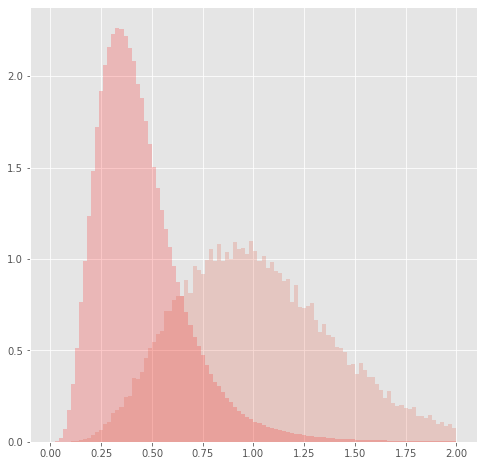

In [180]:
bins = np.linspace(0,2,101)
#plt.ylim((0,250))
plt.hist(bkgloss_rndbkg, color='r', density= True,bins = bins,alpha = 0.2);

#plt.hist(bkgloss_prong2, density= True,bins = bins,alpha = 0.2);
plt.hist(bkgae_loss_list[0],density= True,bins = bins,alpha = 0.2);
#plt.hist(bkgae_loss_list[1],density= True,bins = bins,alpha = 0.2);
#plt.hist(bkgae_loss_list[2],density= True,bins = bins,alpha = 0.2);
#plt.hist(bkgae_loss_list[3],density= True,bins = bins,alpha = 0.2);


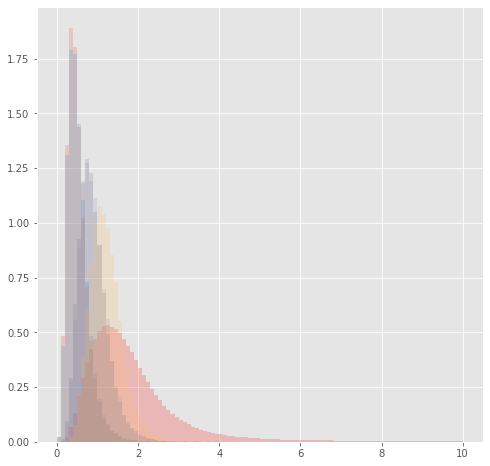

In [174]:
bins = np.linspace(0,10,101)
#plt.ylim((0,250))
plt.hist(sigloss_rndbkg, color='r', density= True,bins = bins,alpha = 0.2);

plt.hist(sigloss_prong2, density= True,bins = bins,alpha = 0.2);
plt.hist(sigae_loss_list[0],density= True,bins = bins,alpha = 0.2);
plt.hist(sigae_loss_list[1],density= True,bins = bins,alpha = 0.2);
plt.hist(sigae_loss_list[2],density= True,bins = bins,alpha = 0.2);
plt.hist(sigae_loss_list[3],density= True,bins = bins,alpha = 0.2);


(0.0, 1.0)

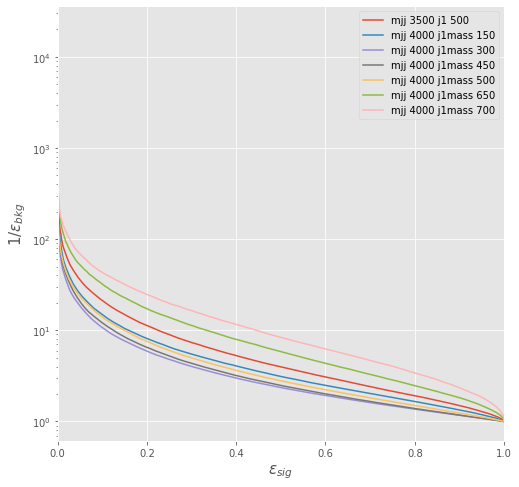

In [66]:
plt.plot(bkgref_tpr_inv,bkgref_fpr_inv,label='mjj 3500 j1 500')
plt.plot(tprlistbkgaej1mass_forinverse[0],fprinverselistbkgaej1mass[0],label='mjj 4000 j1mass 150')
plt.plot(tprlistbkgaej1mass_forinverse[1],fprinverselistbkgaej1mass[1],label='mjj 4000 j1mass 300')
plt.plot(tprlistbkgaej1mass_forinverse[2],fprinverselistbkgaej1mass[2],label='mjj 4000 j1mass 450')
plt.plot(tprlistbkgaej1mass_forinverse[3],fprinverselistbkgaej1mass[3],label='mjj 4000 j1mass 500')
plt.plot(tprlistbkgaej1mass_forinverse[4],fprinverselistbkgaej1mass[4],label='mjj 4000 j1mass 650')
plt.plot(tprlistbkgaej1mass_forinverse[5],fprinverselistbkgaej1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

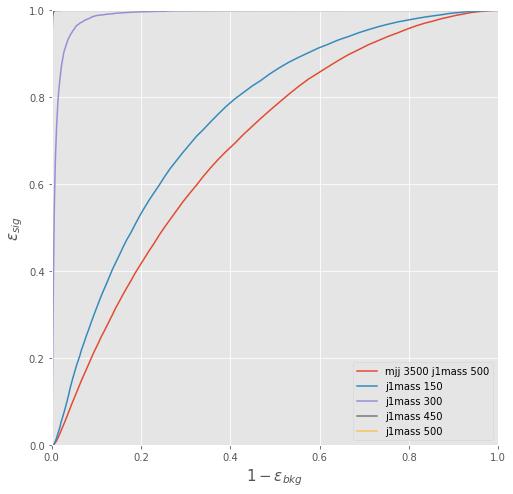

In [68]:
plt.plot(bkgref_fpr,bkgref_tpr,label='mjj 3500 j1mass 500')
#plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
#plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
plt.plot(fprlistbkgaej1mass[0],tprlistbkgaej1mass[0],label='j1mass 150')
plt.plot(fprlistbkgaej1mass[1],tprlistbkgaej1mass[1],label='j1mass 300')
plt.plot(fprlistbkgaej1mass[2],tprlistbkgaej1mass[2],label='j1mass 450')
plt.plot(fprlistbkgaej1mass[3],tprlistbkgaej1mass[3],label='j1mass 500')
#plt.plot(fprlistbkgaej1mass[4],tprlistbkgaej1mass[4],label='j1mass 650')
#plt.plot(fprlistbkgaej1mass[5],tprlistbkgaej1mass[5],label='j1mass 700')



#plt.plot(fprlistj1mass[6],tprlistj1mass[6],label='j1mass 850')
#plt.plot(fprlistj1mass[7],tprlistj1mass[7],label='j1mass 900')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

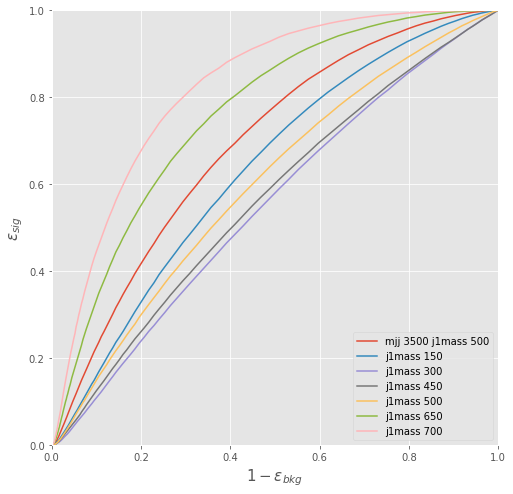

In [68]:
plt.plot(bkgref_fpr,bkgref_tpr,label='mjj 3500 j1mass 500')
#plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
#plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
plt.plot(fprlistbkgaej1mass[0],tprlistbkgaej1mass[0],label='j1mass 150')
plt.plot(fprlistbkgaej1mass[1],tprlistbkgaej1mass[1],label='j1mass 300')
plt.plot(fprlistbkgaej1mass[2],tprlistbkgaej1mass[2],label='j1mass 450')
plt.plot(fprlistbkgaej1mass[3],tprlistbkgaej1mass[3],label='j1mass 500')
plt.plot(fprlistbkgaej1mass[4],tprlistbkgaej1mass[4],label='j1mass 650')
plt.plot(fprlistbkgaej1mass[5],tprlistbkgaej1mass[5],label='j1mass 700')



#plt.plot(fprlistj1mass[6],tprlistj1mass[6],label='j1mass 850')
#plt.plot(fprlistj1mass[7],tprlistj1mass[7],label='j1mass 900')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

In [171]:
tprlistsigaej1mass = []
fprlistsigaej1mass = []
fprinverselistsigaej1mass = []
tprlistsigaej1mass_forinverse = []

sigref_tpr, sigref_fpr = get_tpr_fpr_sig(sigloss_prong2,sigloss_rndbkg)
sigref_tpr_np, sigref_fpr_np = np.array(sigref_tpr), np.array(sigref_fpr)
nonzero_idx = np.nonzero(sigref_fpr_np)
sigref_tpr_inv = sigref_tpr_np[nonzero_idx]
sigref_fpr_inv = 1/sigref_fpr_np[nonzero_idx]


for a in sigae_loss_list:
    tpr, fpr = get_tpr_fpr_sig(a,sigloss_rndbkg)
    #print()
    tprlistsigaej1mass.append(tpr)
    fprlistsigaej1mass.append(fpr)
    fpr_np = np.array(fpr)
    tpr_np = np.array(tpr)
    nonzero_idx = np.nonzero(fpr_np)
    tprlistsigaej1mass_forinverse.append(tpr_np[nonzero_idx])
    fprinverselistsigaej1mass.append(1/fpr_np[nonzero_idx])
    #print(fpr)
    #fprinverselistbkgaej1mass.append(1/fpr_np)

(0.0, 1.0)

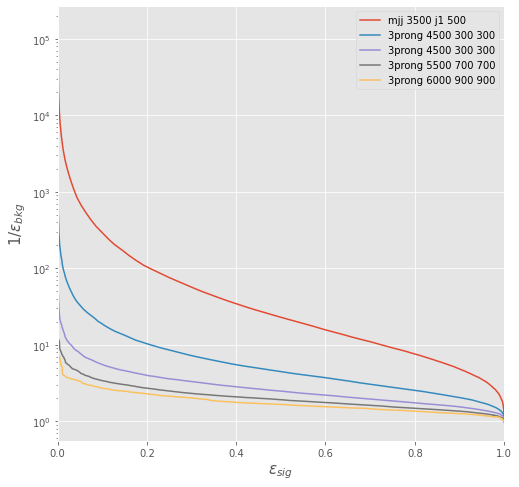

In [72]:
plt.plot(sigref_tpr_inv,sigref_fpr_inv,label='mjj 3500 j1 500')
plt.plot(tprlistsigaej1mass_forinverse[0],fprinverselistsigaej1mass[0],label='3prong 4500 300 300')
plt.plot(tprlistsigaej1mass_forinverse[1],fprinverselistsigaej1mass[1],label='3prong 4500 300 300')
plt.plot(tprlistsigaej1mass_forinverse[2],fprinverselistsigaej1mass[2],label='3prong 5500 700 700')
plt.plot(tprlistsigaej1mass_forinverse[3],fprinverselistsigaej1mass[3],label='3prong 6000 900 900')
#plt.plot(tprlistsigaej1mass_forinverse[4],fprinverselistsigaej1mass[4],label='mjj 4000 j1mass 650')
#plt.plot(tprlistsigaej1mass_forinverse[5],fprinverselistsigaej1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

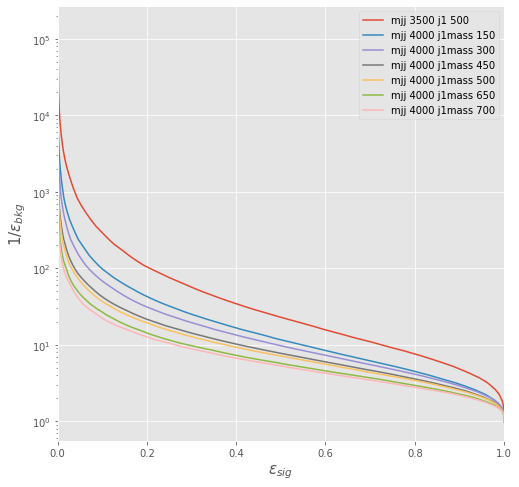

In [70]:
plt.plot(sigref_tpr_inv,sigref_fpr_inv,label='mjj 3500 j1 500')
plt.plot(tprlistsigaej1mass_forinverse[0],fprinverselistsigaej1mass[0],label='mjj 4000 j1mass 150')
plt.plot(tprlistsigaej1mass_forinverse[1],fprinverselistsigaej1mass[1],label='mjj 4000 j1mass 300')
plt.plot(tprlistsigaej1mass_forinverse[2],fprinverselistsigaej1mass[2],label='mjj 4000 j1mass 450')
plt.plot(tprlistsigaej1mass_forinverse[3],fprinverselistsigaej1mass[3],label='mjj 4000 j1mass 500')
plt.plot(tprlistsigaej1mass_forinverse[4],fprinverselistsigaej1mass[4],label='mjj 4000 j1mass 650')
plt.plot(tprlistsigaej1mass_forinverse[5],fprinverselistsigaej1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

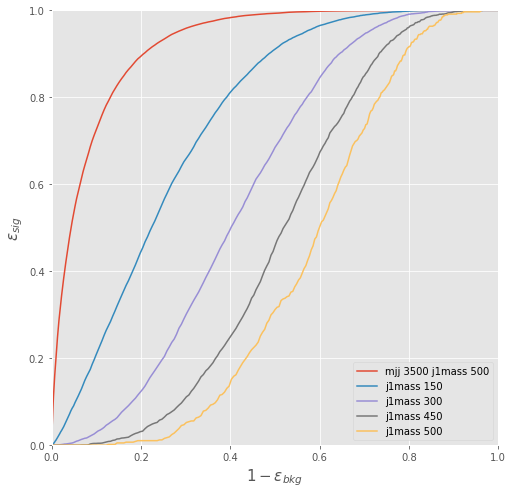

In [74]:
plt.plot(sigref_fpr,sigref_tpr,label='mjj 3500 j1mass 500')
#plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
#plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
plt.plot(fprlistsigaej1mass[0],tprlistsigaej1mass[0],label='j1mass 150')
plt.plot(fprlistsigaej1mass[1],tprlistsigaej1mass[1],label='j1mass 300')
plt.plot(fprlistsigaej1mass[2],tprlistsigaej1mass[2],label='j1mass 450')
plt.plot(fprlistsigaej1mass[3],tprlistsigaej1mass[3],label='j1mass 500')
#plt.plot(fprlistsigaej1mass[4],tprlistsigaej1mass[4],label='j1mass 650')
#plt.plot(fprlistsigaej1mass[5],tprlistsigaej1mass[5],label='j1mass 700')



#plt.plot(fprlistj1mass[6],tprlistj1mass[6],label='j1mass 850')
#plt.plot(fprlistj1mass[7],tprlistj1mass[7],label='j1mass 900')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

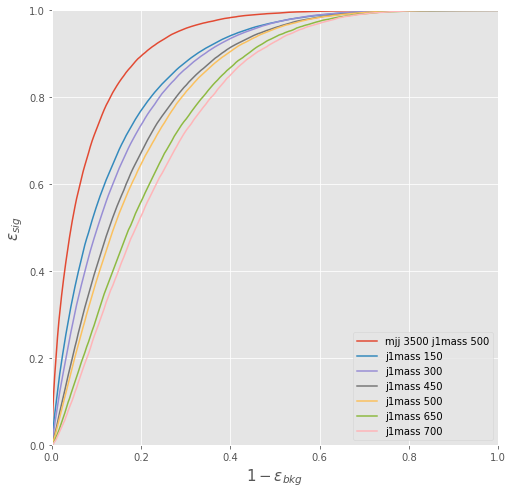

In [71]:
plt.plot(sigref_fpr,sigref_tpr,label='mjj 3500 j1mass 500')
#plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
#plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
plt.plot(fprlistsigaej1mass[0],tprlistsigaej1mass[0],label='j1mass 150')
plt.plot(fprlistsigaej1mass[1],tprlistsigaej1mass[1],label='j1mass 300')
plt.plot(fprlistsigaej1mass[2],tprlistsigaej1mass[2],label='j1mass 450')
plt.plot(fprlistsigaej1mass[3],tprlistsigaej1mass[3],label='j1mass 500')
plt.plot(fprlistsigaej1mass[4],tprlistsigaej1mass[4],label='j1mass 650')
plt.plot(fprlistsigaej1mass[5],tprlistsigaej1mass[5],label='j1mass 700')



#plt.plot(fprlistj1mass[6],tprlistj1mass[6],label='j1mass 850')
#plt.plot(fprlistj1mass[7],tprlistj1mass[7],label='j1mass 900')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

In [92]:
from scipy.spatial import ConvexHull

def get_hull_coordinates(scan_tpr, scan_fpr):
    points = np.array([scan_fpr,scan_tpr])
    points = points.transpose()
    hull = ConvexHull(points)
    fpr = np.array(points[hull.vertices[:],0])
    tpr = np.array(points[hull.vertices[:],1])
    nonzero_idx = np.nonzero(fpr)
    fpr = fpr[nonzero_idx]
    tpr = tpr[nonzero_idx]
    return tpr, fpr 

def get_tpr_fpr_2d(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss):
    bins_sigae = np.arange(0,10,0.2)
    bins_bkgae = np.arange(0,10,0.2)
    tpr = []
    fpr = []
    for sigcut in bins_sigae:
        for bkgcut in bins_bkgae:
            tpr_t = np.where((sigae_sigloss<sigcut)&(bkgae_sigloss>bkgcut))[0].shape[0]/len(sigae_sigloss)
            fpr_t = np.where((sigae_bkgloss<sigcut)&(bkgae_bkgloss>bkgcut))[0].shape[0]/len(sigae_bkgloss)
            tpr.append(tpr_t)
            fpr.append(fpr_t)
            
    tpr, fpr = get_hull_coordinates(tpr, fpr)
                

    return tpr,fpr

tprlistscanj1mass = []
fprlistscanj1mass = []
fprinverselistscanj1mass = []
tprlistscanj1mass_forinverse = []

scanref_tpr, scanref_fpr = get_tpr_fpr_2d(sigloss_prong2,sigloss_rndbkg,bkgloss_prong2,bkgloss_rndbkg)

scanref_tpr_inv = scanref_tpr
scanref_fpr_inv = 1/scanref_fpr


for a,b in zip(sigae_loss_list,bkgae_loss_list):
    tpr, fpr = get_tpr_fpr_2d(a,sigloss_rndbkg,b, bkgloss_rndbkg)
    #print()
    tprlistscanj1mass.append(tpr)
    fprlistscanj1mass.append(fpr)

    tprlistscanj1mass_forinverse.append(tpr)
    fprinverselistscanj1mass.append(1/fpr)
    #print(fpr)
    #fprinverselistbkgaej1mass.append(1/fpr_np)

(0.0, 1.0)

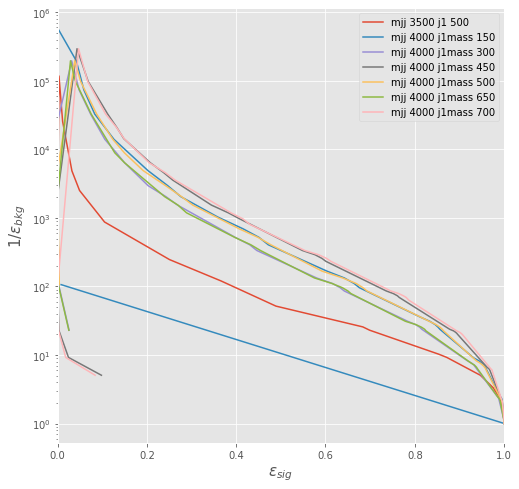

In [96]:
plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='mjj 3500 j1 500')
plt.plot(tprlistscanj1mass_forinverse[0],fprinverselistscanj1mass[0],label='mjj 4000 j1mass 150')
plt.plot(tprlistscanj1mass_forinverse[1],fprinverselistscanj1mass[1],label='mjj 4000 j1mass 300')
plt.plot(tprlistscanj1mass_forinverse[2],fprinverselistscanj1mass[2],label='mjj 4000 j1mass 450')
plt.plot(tprlistscanj1mass_forinverse[3],fprinverselistscanj1mass[3],label='mjj 4000 j1mass 500')
plt.plot(tprlistscanj1mass_forinverse[4],fprinverselistscanj1mass[4],label='mjj 4000 j1mass 650')
plt.plot(tprlistscanj1mass_forinverse[5],fprinverselistscanj1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

IndexError: list index out of range

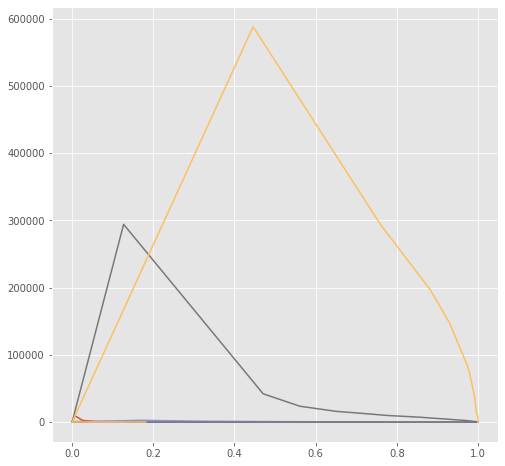

In [93]:
plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='mjj 3500 j1 500')
plt.plot(tprlistscanj1mass_forinverse[0],fprinverselistscanj1mass[0],label='mjj 4000 j1mass 150')
plt.plot(tprlistscanj1mass_forinverse[1],fprinverselistscanj1mass[1],label='mjj 4000 j1mass 300')
plt.plot(tprlistscanj1mass_forinverse[2],fprinverselistscanj1mass[2],label='mjj 4000 j1mass 450')
plt.plot(tprlistscanj1mass_forinverse[3],fprinverselistscanj1mass[3],label='mjj 4000 j1mass 500')
plt.plot(tprlistscanj1mass_forinverse[4],fprinverselistscanj1mass[4],label='mjj 4000 j1mass 650')
plt.plot(tprlistscanj1mass_forinverse[5],fprinverselistscanj1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

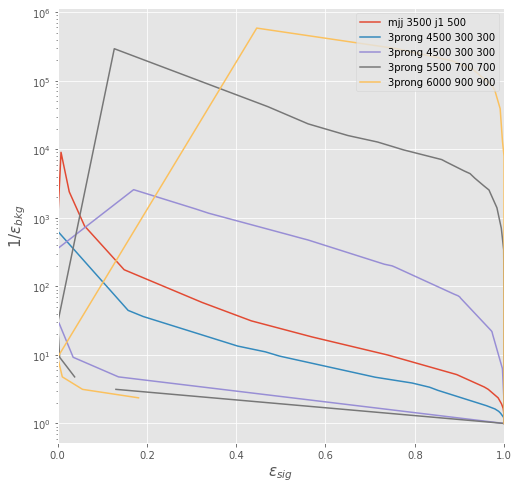

In [94]:
plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='mjj 3500 j1 500')
plt.plot(tprlistscanj1mass_forinverse[0],fprinverselistscanj1mass[0],label='3prong 4500 300 300')
plt.plot(tprlistscanj1mass_forinverse[1],fprinverselistscanj1mass[1],label='3prong 4500 300 300')
plt.plot(tprlistscanj1mass_forinverse[2],fprinverselistscanj1mass[2],label='3prong 5500 700 700')
plt.plot(tprlistscanj1mass_forinverse[3],fprinverselistscanj1mass[3],label='3prong 6000 900 900')
#plt.plot(tprlistscanj1mass_forinverse[4],fprinverselistscanj1mass[4],label='mjj 4000 j1mass 650')
#plt.plot(tprlistscanj1mass_forinverse[5],fprinverselistscanj1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

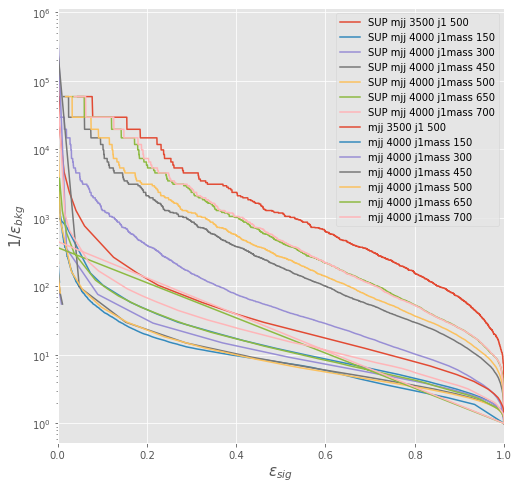

In [120]:
plt.plot(sup_tpr_inv,sup_fpr_inv,label='SUP mjj 3500 j1 500')
plt.plot(tprlistsupj1mass_forinverse[0],fprinverselistsupj1mass[0],label='SUP mjj 4000 j1mass 150')
plt.plot(tprlistsupj1mass_forinverse[1],fprinverselistsupj1mass[1],label='SUP mjj 4000 j1mass 300')
plt.plot(tprlistsupj1mass_forinverse[2],fprinverselistsupj1mass[2],label='SUP mjj 4000 j1mass 450')
plt.plot(tprlistsupj1mass_forinverse[3],fprinverselistsupj1mass[3],label='SUP mjj 4000 j1mass 500')
plt.plot(tprlistsupj1mass_forinverse[4],fprinverselistsupj1mass[4],label='SUP mjj 4000 j1mass 650')
plt.plot(tprlistsupj1mass_forinverse[5],fprinverselistsupj1mass[5],label='SUP mjj 4000 j1mass 700')

plt.plot(scanref_tpr_inv,scanref_fpr_inv,label='mjj 3500 j1 500')
plt.plot(tprlistscanj1mass_forinverse[0],fprinverselistscanj1mass[0],label='mjj 4000 j1mass 150')
plt.plot(tprlistscanj1mass_forinverse[1],fprinverselistscanj1mass[1],label='mjj 4000 j1mass 300')
plt.plot(tprlistscanj1mass_forinverse[2],fprinverselistscanj1mass[2],label='mjj 4000 j1mass 450')
plt.plot(tprlistscanj1mass_forinverse[3],fprinverselistscanj1mass[3],label='mjj 4000 j1mass 500')
plt.plot(tprlistscanj1mass_forinverse[4],fprinverselistscanj1mass[4],label='mjj 4000 j1mass 650')
plt.plot(tprlistscanj1mass_forinverse[5],fprinverselistscanj1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')

plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

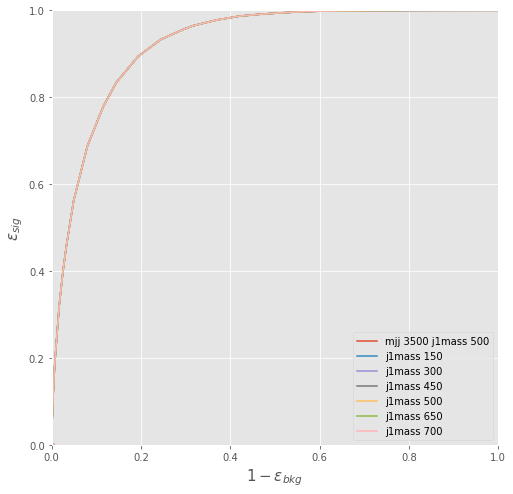

In [115]:
plt.plot(scanref_fpr,scanref_tpr,label='mjj 3500 j1mass 500')
#plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
#plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
plt.plot(fprlistscanj1mass[0],tprlistscanj1mass[0],label='j1mass 150')
plt.plot(fprlistscanj1mass[1],tprlistscanj1mass[1],label='j1mass 300')
plt.plot(fprlistscanj1mass[2],tprlistscanj1mass[2],label='j1mass 450')
plt.plot(fprlistscanj1mass[3],tprlistscanj1mass[3],label='j1mass 500')
plt.plot(fprlistscanj1mass[4],tprlistscanj1mass[4],label='j1mass 650')
plt.plot(fprlistscanj1mass[5],tprlistscanj1mass[5],label='j1mass 700')



#plt.plot(fprlistj1mass[6],tprlistj1mass[6],label='j1mass 850')
#plt.plot(fprlistj1mass[7],tprlistj1mass[7],label='j1mass 900')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

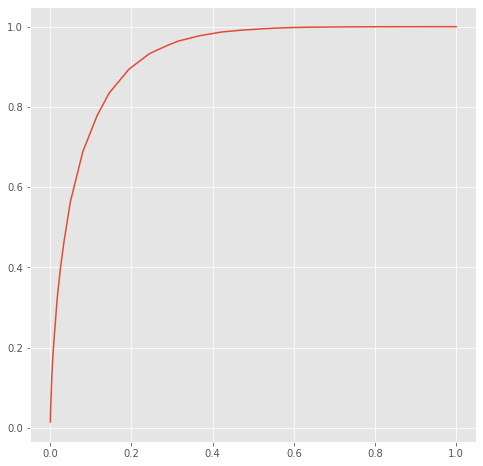

In [88]:
scan_tpr, scan_fpr = get_tpr_fpr_2d(sigloss_prong2,sigloss_rndbkg,bkgloss_prong2,bkgloss_rndbkg)

from scipy.spatial import ConvexHull

points = np.array([scan_fpr,scan_tpr])
points = points.transpose()
hull = ConvexHull(points)

#plt.plot(scan_fpr, scan_tpr)
fpr = np.array(points[hull.vertices[2:],0])
plt.plot(points[hull.vertices[:-10],0], points[hull.vertices[:-10],1])

In [98]:
fpr = np.array(points[hull.vertices[:],0])
tpr = np.array(points[hull.vertices[:],1])
nonzero_idx = np.nonzero(fpr)
fpr = fpr[nonzero_idx]
tpr = tpr[nonzero_idx]

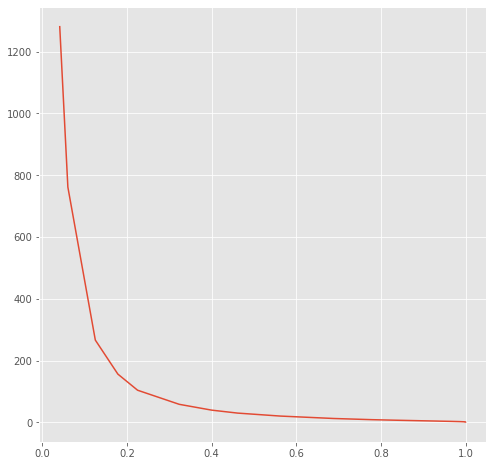

In [103]:
#plt.yscale('log')
plt.plot(tpr[:-10], 1/fpr[:-10])

In [ ]:
for sigloss, bkgloss in zip(sigae):
    

In [63]:
tprlistsigaej1mass = []
fprlistsigaej1mass = []
fprinverselistsigaej1mass = []
for a in sigae_loss_list:
    tpr, fpr = get_tpr_fpr_sig(a,sigloss_rndbkg)
    tprlistsigaej1mass.append(tpr)
    fprlistsigaej1mass.append(fpr)
    fpr_np = np.array(fpr)
    #print(fpr)
    #fprinverselistsigaej1mass.append(1/fpr_np)

In [54]:
testpriorsj1mass = []
sigaelossj1mass = []
for mjj, j1mass, j2mass in varyj1mass_wps:
    print(mjj, j1mass, j2mass)
    f = pd.read_hdf(f"/data/t3home000/spark/QUASAR/preprocessing/delphes_output_{mjj}_{j1mass}_{j2mass}.h5")
    dt = f.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
    correct = (dt[:,0]>mjj-300) & (dt[:,0]<mjj+300)
    dt = dt[correct]

    correct = (dt[:,3]>j1mass-100) & (dt[:,3]<j1mass+100) & (dt[:,19]>j2mass-100) & (dt[:,19]<j2mass+100)
    dt = dt[correct]
    #X = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]]
    #for i in range(26):
    #    X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]
    X = dt[:,[4,5,6,11,12,20,21,22,27,28]]
    for i in range(10):
        X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]
        
    X_testprior = X
    total_bb_test = torch.tensor(X)
    
    #Xae = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]]
    #for i in range(26):
    #    Xae[:,i] = (Xae[:,i]-sig_mean[i])/sig_std[i]
    Xae = dt[:,[4,5,6,11,12,20,21,22,27,28]]
    for i in range(10):
        Xae[:,i] = (Xae[:,i]-sig_mean[i])/sig_std[i]

    X.shape

    testprior_data = testData(torch.FloatTensor(X_testprior.astype(np.float))) 
    testprior_loader = utils.DataLoader(dataset=testprior_data, batch_size=100)

    y_testpriorlist = []
    with torch.no_grad():
        for batch_idx, X_batch in enumerate(testprior_loader):
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            #y_pred_tag = torch.round(y_test_pred)
            y_testpriorlist = np.append(y_testpriorlist,y_test_pred.cpu().numpy())


    print(len(y_testpriorlist))
    testpriorsj1mass.append(y_testpriorlist)
    
    sigae_bbloss = torch.mean((sigmodel(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    sigaelossj1mass.append(sigae_bbloss)
    

4000 150 150
50885


NameError: name 'sigmodel' is not defined

In [104]:
loss_rndbkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy")
loss_prong2 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy")


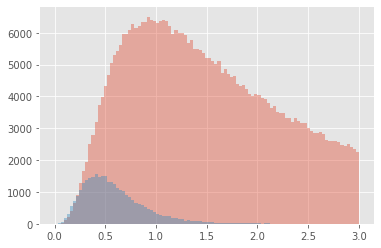

In [107]:
#plt.hist(sigaelossj1mass[0],bins=np.linspace(0,3,100));
#plt.hist(sigaelossj1mass[1],bins=np.linspace(0,3,100));
#plt.hist(sigaelossj1mass[2],bins=np.linspace(0,3,100));
#plt.hist(sigaelossj1mass[3],bins=np.linspace(0,3,100));
plt.hist(loss_rndbkg,alpha=0.4,bins=np.linspace(0,3,100));
plt.hist(loss_prong2,alpha=0.4,bins=np.linspace(0,3,100));

In [121]:
def get_tpr_fpr_sig(sigloss,bkgloss):
    bins = np.arange(0.1,20,.1)
    tpr = []
    fpr = []
    for cut in bins:
        #print(sigloss)
        #print(bkgloss)
        #print("fpr:",np.where(bkgloss<cut)[0].shape[0]/len(bkgloss),"tpr",np.where(sigloss<cut)[0].shape[0]/len(sigloss))
        tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))

    return fpr,tpr

In [127]:
def_fpr, def_tpr = get_tpr_fpr_sig(loss_prong2,loss_rndbkg)

In [128]:
def_fpr_np = np.array(def_fpr)
def_fprinverse = 1/def_fpr_np

In [123]:
tprlistsigaej1mass = []
fprlistsigaej1mass = []
fprinverselistsigaej1mass = []
for a in sigaelossj1mass:
    fpr, tpr = get_tpr_fpr_sig(a,loss_rndbkg)
    tprlistsigaej1mass.append(tpr)
    fprlistsigaej1mass.append(fpr)
    fpr_np = np.array(fpr)
    #print(fpr)
    fprinverselistsigaej1mass.append(1/fpr_np)

(0.0, 1.0)

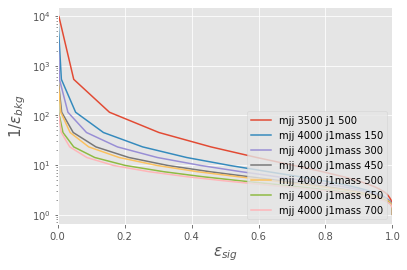

In [130]:
plt.plot(def_tpr,def_fprinverse,label='mjj 3500 j1 500')
plt.plot(tprlistsigaej1mass[0],fprinverselistsigaej1mass[0],label='mjj 4000 j1mass 150')
plt.plot(tprlistsigaej1mass[1],fprinverselistsigaej1mass[1],label='mjj 4000 j1mass 300')
plt.plot(tprlistsigaej1mass[2],fprinverselistsigaej1mass[2],label='mjj 4000 j1mass 450')
plt.plot(tprlistsigaej1mass[3],fprinverselistsigaej1mass[3],label='mjj 4000 j1mass 500')
plt.plot(tprlistsigaej1mass[4],fprinverselistsigaej1mass[4],label='mjj 4000 j1mass 650')
plt.plot(tprlistsigaej1mass[5],fprinverselistsigaej1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')


plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

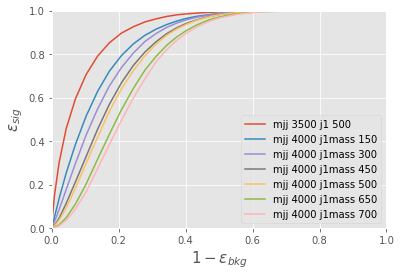

In [114]:
plt.plot(def_fpr,def_tpr,label='mjj 3500 j1 500')

plt.plot(fprlistsigaej1mass[0],tprlistsigaej1mass[0],label='mjj 4000 j1mass 150')
plt.plot(fprlistsigaej1mass[1],tprlistsigaej1mass[1],label='mjj 4000 j1mass 300')
plt.plot(fprlistsigaej1mass[2],tprlistsigaej1mass[2],label='mjj 4000 j1mass 450')
plt.plot(fprlistsigaej1mass[3],tprlistsigaej1mass[3],label='mjj 4000 j1mass 500')
plt.plot(fprlistsigaej1mass[4],tprlistsigaej1mass[4],label='mjj 4000 j1mass 650')
plt.plot(fprlistsigaej1mass[5],tprlistsigaej1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

In [125]:
testpriors2 = []
for mjj, j1mass, j2mass in threeprong_wps:
    print(mjj, j1mass, j2mass)
    f = pd.read_hdf(f"/data/t3home000/spark/QUASAR/preprocessing/ThreeProng_{mjj}_{j1mass}_{j2mass}.h5")
    dt = f.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
    correct = (dt[:,0]>mjj-300) & (dt[:,0]<mjj+300)
    dt = dt[correct]

    correct = (dt[:,3]>j1mass-100) & (dt[:,3]<j1mass+100) & (dt[:,19]>j2mass-100) & (dt[:,19]<j2mass+100)
    dt = dt[correct]
    X = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]]
    for i in range(26):
        X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]
        
    X_testprior = X

    X.shape

    testprior_data = testData(torch.FloatTensor(X_testprior.astype(np.float))) 
    testprior_loader = utils.DataLoader(dataset=testprior_data, batch_size=100)

    y_testpriorlist = []
    with torch.no_grad():
        for batch_idx, X_batch in enumerate(testprior_loader):
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            #y_pred_tag = torch.round(y_test_pred)
            y_testpriorlist = np.append(y_testpriorlist,y_test_pred.cpu().numpy())


    print(len(y_testpriorlist))
    testpriors2.append(y_testpriorlist)
    
    

6000 900 900
574
4500 300 300
14086


In [126]:
testpriors = []
for mjj, j1mass, j2mass in twoprong_wps:
    print(mjj, j1mass, j2mass)
    f = pd.read_hdf(f"/data/t3home000/spark/QUASAR/preprocessing/delphes_output_{mjj}_{j1mass}_{j2mass}.h5")
    dt = f.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
    correct = (dt[:,0]>mjj-300) & (dt[:,0]<mjj+300)
    dt = dt[correct]

    correct = (dt[:,3]>j1mass-100) & (dt[:,3]<j1mass+100) & (dt[:,19]>j2mass-100) & (dt[:,19]<j2mass+100)
    dt = dt[correct]
    X = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]]
    for i in range(26):
        X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]
        
    X_testprior = X

    X.shape

    testprior_data = testData(torch.FloatTensor(X_testprior.astype(np.float))) 
    testprior_loader = utils.DataLoader(dataset=testprior_data, batch_size=100)

    y_testpriorlist = []
    with torch.no_grad():
        for batch_idx, X_batch in enumerate(testprior_loader):
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            #y_pred_tag = torch.round(y_test_pred)
            y_testpriorlist = np.append(y_testpriorlist,y_test_pred.cpu().numpy())


    print(len(y_testpriorlist))
    testpriors.append(y_testpriorlist)
    
    

3200 500 150
31614
4000 500 150
36079
4500 500 150
33887
5000 500 150
29551
5500 500 150
23878
6000 500 150
17214


In [105]:
len(testpriors)

6

In [85]:
model.eval()
y_pred_list = np.array([],dtype=np.float)
with torch.no_grad():
    for batch_idx, X_batch in enumerate(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_pred_list = np.append(y_pred_list,y_test_pred.cpu().numpy())
        

truesig = np.where(y_test==1)
truebkg = np.where(y_test==0)
sigscore = y_pred_list[truesig]
bkgscore = y_pred_list[truebkg]

plt.style.use('ggplot')

plt.hist(bkgscore,bins=np.linspace(0,1,101),alpha=.5,density=True);
plt.hist(sigscore,bins=np.linspace(0,1,101),alpha=.5,density=True);

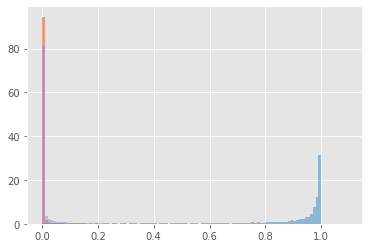

In [123]:
plt.style.use('ggplot')

plt.hist(bkgscore,bins=bins,alpha=.5,density=True);
plt.hist(sigscore,bins=bins,alpha=.5,density=True);
#plt.hist(testpriors[0],bins=bins,alpha=0.2,density=True);
#plt.hist(testpriors[1],bins=bins,alpha=0.2,density=True);
#plt.hist(testpriors[2],bins=bins,alpha=0.2,density=True);
plt.hist(testpriors[5],bins=bins,alpha=0.5,density=True);

In [90]:
def get_tpr_fpr(sigscore,bkgscore):
    bins = np.linspace(0,1,10001)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigscore>cut)[0].shape[0]/len(sigscore))
        fpr.append(np.where(bkgscore>cut)[0].shape[0]/len(bkgscore))

    return tpr,fpr

In [129]:
tprlist = []
fprlist = []
for a in testpriors:
    tpr, fpr = get_tpr_fpr(a,bkgscore)
    tprlist.append(tpr)
    fprlist.append(fpr)
    

In [130]:
tprlist3p = []
fprlist3p = []
for a in testpriors2:
    tpr, fpr = get_tpr_fpr(a,bkgscore)
    tprlist3p.append(tpr)
    fprlist3p.append(fpr)

In [91]:
tprlistj1mass = []
fprlistj1mass = []
for a in testpriorsj1mass:
    tpr, fpr = get_tpr_fpr(a,bkgscore)
    tprlistj1mass.append(tpr)
    fprlistj1mass.append(fpr)

In [93]:
sup_tpr, sup_fpr = get_tpr_fpr(sigscore,bkgscore)

In [133]:
sup_fpr = np.array(sup_fpr)

(0.0, 1.0)

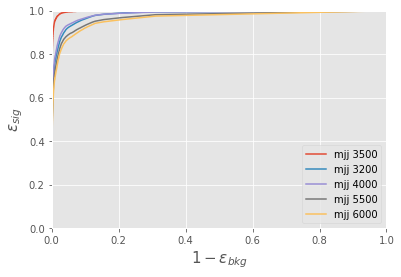

In [134]:
plt.plot(sup_fpr,sup_tpr,label='mjj 3500')
plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
plt.plot(fprlist[5],tprlist[5],label='mjj 6000')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(0.0, 1.0)

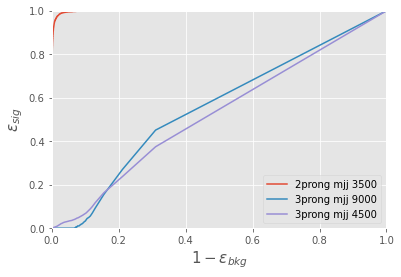

In [136]:
plt.plot(sup_fpr,sup_tpr,label='2prong mjj 3500')
#plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
#plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
plt.plot(fprlist3p[0],tprlist3p[0],label='3prong mjj 9000')
plt.plot(fprlist3p[1],tprlist3p[1],label='3prong mjj 4500')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

In [138]:
varyj1mass_wps

([4000, 150, 150],
 [4000, 300, 150],
 [4000, 450, 150],
 [4000, 500, 150],
 [4000, 650, 150],
 [4000, 700, 150],
 [4000, 850, 150],
 [4000, 900, 150])

(0.0, 1.0)

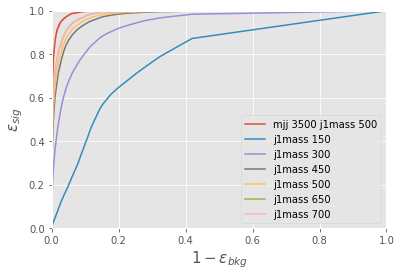

In [115]:
plt.plot(sup_fpr,sup_tpr,label='mjj 3500 j1mass 500')
#plt.plot(fprlist[0],tprlist[0],label='mjj 3200')
#plt.plot(fprlist[1],tprlist[1],label='mjj 4000')
#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
plt.plot(fprlistj1mass[0],tprlistj1mass[0],label='j1mass 150')
plt.plot(fprlistj1mass[1],tprlistj1mass[1],label='j1mass 300')
plt.plot(fprlistj1mass[2],tprlistj1mass[2],label='j1mass 450')
plt.plot(fprlistj1mass[3],tprlistj1mass[3],label='j1mass 500')
plt.plot(fprlistj1mass[4],tprlistj1mass[4],label='j1mass 650')
plt.plot(fprlistj1mass[5],tprlistj1mass[5],label='j1mass 700')



#plt.plot(fprlistj1mass[6],tprlistj1mass[6],label='j1mass 850')
#plt.plot(fprlistj1mass[7],tprlistj1mass[7],label='j1mass 900')



plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_Curve_zdim_fnum.png')

In [75]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 10)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

    
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from models import NormalizingFlowModel

sigmodel = VAE_NF(N_FLOWS, Z_DIM).cuda()

ae_def = {
    "type":"sig",
    "trainon":"2prong",
    "features":"10features",
    "architecture":"MAF",
    "selection":"masscuts",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z8f8",
}

sigmodel.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))

In [ ]:
sigae_bbloss = torch.mean((sigmodel(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [94]:
f = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/ThreeProng_6000_900_900.h5")

In [95]:
dt = f.values
#correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)

dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


#correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
#dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#signal_idx = np.where((idx==1) & (dt[:,3]>300))[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
    
#bsmlike = np.where(dt[:,16]>0.9)[0]
#dt = dt[bsmlike]

correct = (dt[:,0]>5000)
dt = dt[correct]

correct = (dt[:,3]>700) & (dt[:,19]>400)
dt = dt[correct]





'''
dt.shape

j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.088
tau32prime = tau32 + rhoprime * 0.025
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.001

j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.086
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

dt.shape
'''

In [73]:
#X = dt[:,[3,4,5,6,7,8,11,12,19,20,21,22,23,24,27,28]]
X = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]]
for i in range(26):
    X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]

In [107]:
X_wrongprior = X

X.shape

wrongprior_data = testData(torch.FloatTensor(X_wrongprior.astype(np.float))) 
wrongprior_loader = utils.DataLoader(dataset=wrongprior_data, batch_size=100)

y_wrongpriorlist = []
with torch.no_grad():
    for batch_idx, X_batch in enumerate(wrongprior_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_wrongpriorlist = np.append(y_wrongpriorlist,y_test_pred.cpu().numpy())
        

len(y_wrongpriorlist)

7535

In [83]:
model.eval()
y_pred_list = np.array([],dtype=np.float)
with torch.no_grad():
    for batch_idx, X_batch in enumerate(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_pred_list = np.append(y_pred_list,y_test_pred.cpu().numpy())
        


truesig = np.where(y_test==1)
truebkg = np.where(y_test==0)
sigscore = y_pred_list[truesig]
bkgscore = y_pred_list[truebkg]

In [81]:
bins = np.arange(-20,20,1)

NameError: name 'y_wrongpriorlist' is not defined

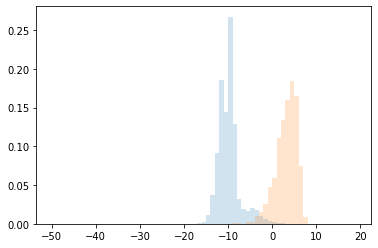

In [76]:
plt.hist(bkgscore,bins=bins,alpha=.2,density=True);
plt.hist(sigscore,bins=bins,alpha=.2,density=True);
plt.hist(y_wrongpriorlist,bins=bins,alpha=0.2,density=True);


In [124]:
def get_tpr_fpr_supervised(sigloss,bkgloss):
    bins = np.arange(-20,20,.01)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))

    return tpr,fpr

In [115]:
def get_tpr_fpr_supervised(sigloss,bkgloss):
    bins = np.arange(-20,20,.01)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        a = np.where(bkgloss>cut)[0].shape[0]/len(bkgloss)
        if a==0:
            fpr.append(1e8)
            continue
        fpr.append(1/a)

    return tpr,fpr

In [125]:
sup_tpr, sup_fpr = get_tpr_fpr_supervised(sigscore,bkgscore)

In [126]:
approx_tpr,approx_fpr = get_tpr_fpr_supervised(y_wrongpriorlist,bkgscore)

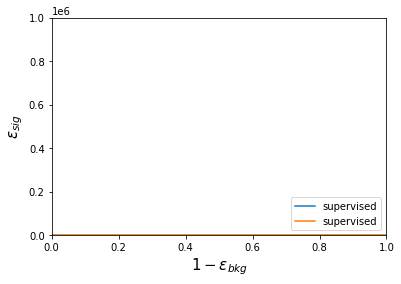

In [128]:
plt.plot(sup_fpr,sup_tpr,label='supervised')
plt.plot(approx_fpr,approx_tpr,label='supervised')

#plt.plot(justlossfpr5t,justlosstpr5t,label='MSE_5taus')
#plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
#plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1000000.0])
plt.savefig('ROC_optimalcase_approaches_FULLYSUPERVISED.png')

In [111]:
bkgae_bkgloss = np.load('../data_strings/bkg_purebkg_NoDDT_withm1andm2_mjj_mj1_mj2_cut_MSELoss_beta1_z8f8_Justloss_rndbkg.npy')
bkgae_sigloss = np.load('../data_strings/bkg_purebkg_NoDDT_withm1andm2_mjj_mj1_mj2_cut_MSELoss_beta1_z8f8_Justloss_2prong.npy')

In [112]:
sigae_sigloss = np.load('../data_strings/sig_2prong_noddtnomass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z8f8_Justloss_2prong.npy')
sigae_bkgloss = np.load('../data_strings/sig_2prong_noddtnomass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z8f8_Justloss_rndbkg.npy')

In [113]:
sigae2_sigloss = np.load('../data_strings/sig_3prong_noddtnomass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z8f8_Justloss_2prong.npy')
sigae2_bkgloss = np.load('../data_strings/sig_3prong_noddtnomass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z8f8_Justloss_rndbkg.npy')

In [114]:
def get_tpr_fpr_bkg(sigloss,bkgloss):
    bins = np.arange(0,20,.01)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))

    return fpr,tpr

In [115]:
def get_tpr_fpr_sig(sigloss,bkgloss):
    bins = np.arange(0,20,.01)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))

    return fpr,tpr

In [116]:
bkgae_fpr, bkgae_tpr = get_tpr_fpr_bkg(bkgae_sigloss,bkgae_bkgloss)

In [117]:
sigae_fpr, sigae_tpr = get_tpr_fpr_sig(sigae_sigloss,sigae_bkgloss)

In [118]:
sigae2_fpr, sigae2_tpr = get_tpr_fpr_sig(sigae2_sigloss,sigae2_bkgloss)

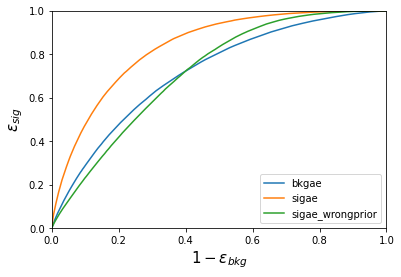

In [119]:
#plt.plot(sup_fpr,sup_tpr,label='supervised')
plt.plot(bkgae_fpr,bkgae_tpr,label='bkgae')
plt.plot(sigae_fpr,sigae_tpr,label='sigae')
plt.plot(sigae2_fpr,sigae2_tpr,label='sigae_wrongprior')

#plt.plot(justlossfpr5t,justlosstpr5t,label='MSE_5taus')
#plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
#plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_wrongprior.png')

In [158]:
def get_tpr_fpr_2d_new(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss):
    bins_sigae = np.arange(0,0,.1)
    bins_bkgae = np.arange(0,0,.1)
    tpr = []
    fpr = []
    for sigcut in bins_sigae:
        compare = -0.1
        tpr_temp = 0
        fpr_temp = 0 
        for bkgcut in bins_bkgae:
            tpr_t = np.where((sigae_sigloss<sigcut)&(bkgae_sigloss>bkgcut))[0].shape[0]/len(sigae_sigloss)
            fpr_t = np.where((sigae_bkgloss<sigcut)&(bkgae_bkgloss>bkgcut))[0].shape[0]/len(sigae_bkgloss)
            
            if fpr_t == 0:
                fpr_t = 1000000000
            ratio = tpr_t/fpr_t
            
            if sigcut == 1.0 and bkgcut==1.0:
                print(tpr_t,fpr_t,ratio)
                
            if ratio > compare:
                compare = ratio
                tpr_temp = tpr_t
                fpr_temp = fpr_t
        tpr.append(tpr_temp)
        fpr.append(fpr_temp)
                

    return tpr,fpr  

In [120]:
scan_tpr, scan_fpr = get_tpr_fpr_2d(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss)

In [121]:
scan2_tpr, scan2_fpr = get_tpr_fpr_2d(sigae2_sigloss,sigae2_bkgloss,bkgae_sigloss,bkgae_bkgloss)

In [105]:
def get_tpr_fpr_2d(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss):
    bins_sigae = np.arange(0,20,.1)
    bins_bkgae = np.arange(0,20,.1)
    tpr = []
    fpr = []
    for sigcut in bins_sigae:
        for bkgcut in bins_bkgae:
            tpr_t = np.where((sigae_sigloss<sigcut)&(bkgae_sigloss>bkgcut))[0].shape[0]/len(sigae_sigloss)
            fpr_t = np.where((sigae_bkgloss<sigcut)&(bkgae_bkgloss>bkgcut))[0].shape[0]/len(sigae_bkgloss)
            tpr.append(tpr_t)
            fpr.append(fpr_t)
                

    return tpr,fpr

scan_tpr, scan_fpr = get_tpr_fpr_2d(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss)

from scipy.spatial import ConvexHull







points = np.array([scan_fpr,scan_tpr])

points = points.transpose()

hull = ConvexHull(points)

plt.plot(points[hull.vertices[2:],0], points[hull.vertices[2:],1])

In [127]:
points2 = np.array([scan2_fpr,scan2_tpr])

In [128]:
points2 = points2.transpose()

In [129]:
hull2 = ConvexHull(points2)

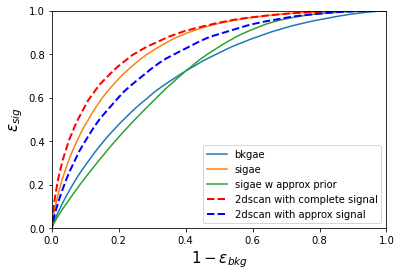

In [143]:
#plt.plot(sup_fpr,sup_tpr,label='supervised')
plt.plot(bkgae_fpr,bkgae_tpr,label='bkgae')
plt.plot(sigae_fpr,sigae_tpr,label='sigae')
plt.plot(sigae2_fpr,sigae2_tpr,label='sigae w approx prior')

plt.plot(points[hull.vertices[2:],0], points[hull.vertices[2:],1], 'r--', lw=2,label='2dscan with complete signal')
plt.plot(points2[hull2.vertices[2:],0], points2[hull2.vertices[2:],1], 'b--', lw=2,label='2dscan with approx signal')

#plt.plot(justlossfpr5t,justlosstpr5t,label='MSE_5taus')
#plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
#plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.])
plt.ylim([0.0,1.0])
plt.savefig('ROC_optimalcase_approaches_FULLYSUPERVISED.png')

In [222]:
bb1 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5")

dt = bb1.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#signal_idx = np.where((idx==1) & (dt[:,3]>300))[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
    
bsmlike = np.where(dt[:,16]>0.9)[0]
dt = dt[bsmlike]


dt.shape

j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.0775
tau32prime = tau32 + rhoprime * 0.027
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.004

j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.088
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

dt.shape

X = dt[:,[4,5,6,7,8,11,12,20,21,22,23,24,27,28]]

for i in range(14):
    X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]

X_bb = X

X_bb.shape

bb_data = testData(torch.FloatTensor(X_bb.astype(np.float))) 
bb_loader = utils.DataLoader(dataset=bb_data, batch_size=100)

y_bb = []
with torch.no_grad():
    for batch_idx, X_batch in enumerate(bb_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_bb = np.append(y_bb,y_test_pred.cpu().numpy())
        



In [223]:
mass = dt[:,0]

(array([9.00000e+00, 5.58000e+02, 9.20300e+03, 3.67500e+04, 6.77230e+04,
        1.03113e+05, 8.39410e+04, 7.20000e+04, 6.31530e+04, 4.19920e+04,
        1.34320e+04, 5.51500e+03, 1.85400e+03, 3.30000e+02, 2.90000e+01,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9]),
 <a list of 19 Patch objects>)

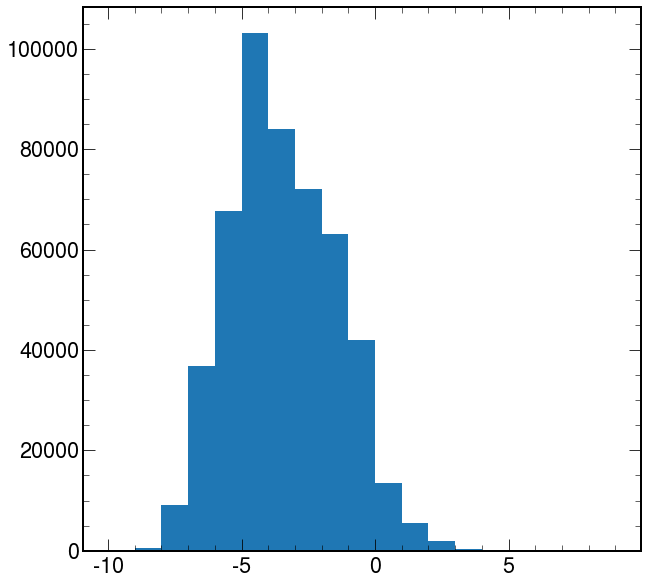

In [224]:
plt.hist(y_bb, bins=np.arange(-10,10,1))

In [225]:
len(np.where(y_bb>2.3)[0])

1399

In [226]:
import mplhep as hep
import mplhep.label as label_base
plt.style.use(hep.style.CMS)

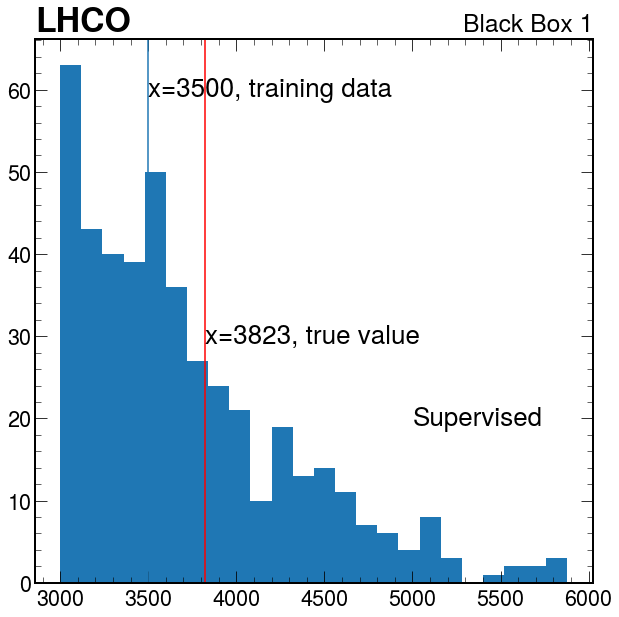

In [227]:
plt.hist(mass[y_bb>2.5], bins=np.arange(3000,6000,120))
plt.axvline(x=3500)
plt.text(3500, 60, "x=3500, training data",  verticalalignment='center')

plt.axvline(x=3823,color='r')

plt.text(3823, 30, "x=3823, true value",  verticalalignment='center')

plt.text(5000, 20, "Supervised",  verticalalignment='center')
hep.label.lumitext("Black Box 1")
label_base._exp_text("LHCO")
plt.savefig('bb1_supervised.png')


In [263]:
bb1 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5")

dt = bb1.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#signal_idx = np.where((idx==1) & (dt[:,3]>300))[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
    
bsmlike = np.where(dt[:,16]>0.9)[0]
dt = dt[bsmlike]


dt.shape

j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.0775
tau32prime = tau32 + rhoprime * 0.027
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.004

j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.088
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

dt.shape

X = dt[:,[4,5,6,7,8,11,12,20,21,22,23,24,27,28]]

for i in range(14):
    X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]

X_bb = X

X_bb.shape

bb_data = testData(torch.FloatTensor(X_bb.astype(np.float))) 
bb_loader = utils.DataLoader(dataset=bb_data, batch_size=100)

y_bb = []
with torch.no_grad():
    for batch_idx, X_batch in enumerate(bb_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_bb = np.append(y_bb,y_test_pred.cpu().numpy())
        



In [264]:
mass = dt[:,0]

plt.hist(mass[y_bb>3.4], bins=np.arange(3000,6000,150))
plt.axvline(x=3500)
plt.text(3500, 20, "x=3500, training data",  verticalalignment='center')

#plt.axvline(x=3823,color='r')

#plt.text(3823, 15, "True value unknown",  verticalalignment='center')

plt.text(5000, 10, "Supervised",  verticalalignment='center')
hep.label.lumitext("Black Box 2")
label_base._exp_text("LHCO")
plt.savefig('bb2_supervised.png')

In [277]:
bb1 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5")

dt = bb1.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#signal_idx = np.where((idx==1) & (dt[:,3]>300))[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
    
bsmlike = np.where(dt[:,16]>0.9)[0]
dt = dt[bsmlike]


dt.shape

j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.0775
tau32prime = tau32 + rhoprime * 0.027
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.004

j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.088
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

dt.shape

X = dt[:,[4,5,6,7,8,11,12,20,21,22,23,24,27,28]]

for i in range(14):
    X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]

X_bb = X

X_bb.shape

bb_data = testData(torch.FloatTensor(X_bb.astype(np.float))) 
bb_loader = utils.DataLoader(dataset=bb_data, batch_size=100)

y_bb = []
with torch.no_grad():
    for batch_idx, X_batch in enumerate(bb_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_bb = np.append(y_bb,y_test_pred.cpu().numpy())
        



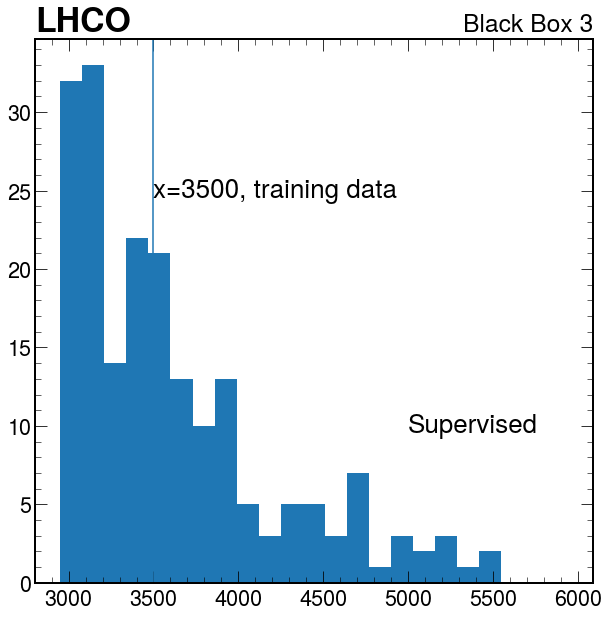

In [318]:
mass = dt[:,0]

plt.hist(mass[y_bb>2.1], bins=np.arange(2950,6000,130))
plt.axvline(x=3500)


plt.text(3500, 25, "x=3500, training data",  verticalalignment='center')

#plt.axvline(x=3823,color='r')

#plt.text(3823, 15, "True value unknown",  verticalalignment='center')

plt.text(5000, 10, "Supervised",  verticalalignment='center')



hep.label.lumitext("Black Box 3")
label_base._exp_text("LHCO")
plt.savefig('bb3_supervised.png')

In [142]:
sigscore.shape

(6716,)

In [143]:
print(sigscore)

[-0.71345681 -0.68024683  2.09297943 ... -4.48688602  3.87274647
  3.30166578]


In [70]:
bkgscore.shape

(99844,)

In [71]:
print(y_pred_list.shape,y_test.shape)
print(y_pred_list[:20],y_test[:20])

(110000,) (110000,)
[6.01285370e-03 1.40656037e-02 6.33050862e-04 9.06132385e-02
 4.29636799e-03 2.59291963e-04 2.91777588e-03 9.88843734e-04
 1.93072669e-03 2.13927981e-02 2.22644396e-03 3.17776599e-03
 7.99695496e-03 6.96382206e-03 3.63481743e-03 5.33045316e-03
 5.50930796e-04 1.47437686e-02 5.34979522e-01 2.88454480e-02] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [86]:
def get_tpr_fpr(sigloss,bkgloss):
    bins = np.linspace(0,1,100001)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    
    return tpr,fpr  

In [87]:
tpr, fpr = get_tpr_fpr(sigscore,bkgscore)

In [89]:
np.save('supervised_ref_tpr.npy',tpr)
np.save('supervised_ref_fpr.npy',fpr)

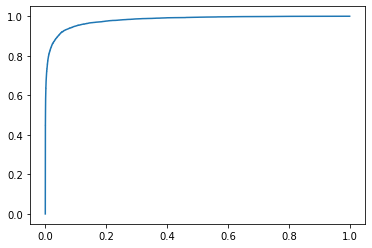

In [88]:
plt.plot(fpr,tpr)

In [77]:
max(0,1e-6)

1e-06

In [91]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,1,100001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            if (np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]) != 0:
                tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
                precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [92]:
precision, recall = get_precision_recall(sigscore,bkgscore)

In [94]:
np.save('supervised_ref_precision.npy',precision)
np.save('supervised_ref_recall.npy',recall)

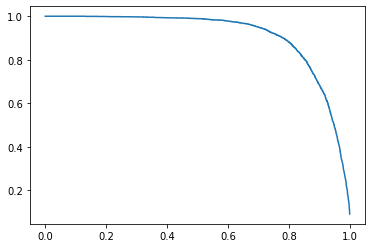

In [95]:
plt.plot(recall,precision)

# Now time to train a simple NN

In [ ]:
plt.hist(data_branches[b'vjet0_msd0'][y_pred_list>-40],1000)

In [ ]:
data

In [ ]:
f = uproot.update("data/JetHT_s.root")

In [ ]:
data   = uproot.open("data/JetHT_s.root")["Tree"]
data.extend({"NN_score":y_pred_list})

In [ ]:
import numpy as np

In [ ]:
N, D_in, H, D_out = 64, 1000, 100, 10

In [ ]:
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

In [ ]:
print(x.shape)

In [ ]:
# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

In [ ]:
learning_rate = 1e-6

In [ ]:
for i in range(500):
    #forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h,0)
    y_pred = h_relu.dot(w2)
    
    loss = np.square(y_pred-y).sum()
    print(t,loss)
    
    # back propagation
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2  = h_relu.T.dot(grad_y_pred)
    g
    
    
    